# Traffic Analysis using Random Forest Regression

**Group**: G3  
**Project**: Traffic Analysis for Howest Campus (CTAI)  
**Team**: Hadi, Rares, Hamzzah  
**Date**: January 2026

---

## Overview
This notebook analyzes traffic patterns around Howest Campus using Random Forest regression models to predict traffic volumes across different transportation modes (car, bike, pedestrian, heavy vehicles) and evaluate the impact of parking scenarios on traffic flow.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
df = pd.read_csv("data/traffic_weather_merged.csv")
df.head()



instance_id  segment_id                       date interval    uptime  \
0           -1  9000008372  2025-11-21 09:00:00+01:00   hourly  0.499722   
1           -1  9000008372  2025-11-21 10:00:00+01:00   hourly  0.999444   
2           -1  9000008372  2025-11-21 11:00:00+01:00   hourly  0.999167   
3           -1  9000008372  2025-11-21 12:00:00+01:00   hourly  0.999722   
4           -1  9000008372  2025-11-21 13:00:00+01:00   hourly  0.999167   

   heavy   car  bike  pedestrian  night  ...      timezone   v85  \
0    0.0  34.0   4.0         4.0    0.0  ...  Europe/Paris  27.5   
1    0.0  39.0  11.0         6.0    0.0  ...  Europe/Paris  25.5   
2    2.0  31.0  16.0         6.0    0.0  ...  Europe/Paris  29.5   
3    1.0  47.0  30.0        20.0    0.0  ...  Europe/Paris  32.5   
4    1.0  26.0  19.0        36.0    0.0  ...  Europe/Paris  35.5   

            street_name  temperature_c  precipitation_mm  rain_mm  \
0  Sintmartenslatemlaan            0.2               0.0      0.0   
1  Sintmartenslatemlaan            0.8               0.0      0.0   
2  Sintmartenslatemlaan            1.3               0.0      0.0   
3  Sintmartenslatemlaan            2.4               0.0      0.0   
4  Sintmartenslatemlaan            2.6               0.0      0.0   

   snowfall_cm  cloud_cover_pct  wind_speed_kmh  sunshine_duration_s  
0          0.0              100            12.2                 6.59  
1          0.0              100            13.4              3600.00  
2          0.0              100            11.0               672.91  
3          0.0               98             9.6              3600.00  
4          0.0              100             9.2              3600.00  

[5 rows x 33 columns]

In [3]:
# convert ISO timestamp string to real datetime
df["datetime"] = pd.to_datetime(df["date"])  # your date column already has timestamp
df["date_only"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek  # 0=Mon
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

df[["datetime", "hour", "dayofweek", "is_weekend"]].head()

datetime  hour  dayofweek  is_weekend
0 2025-11-21 09:00:00+01:00     9          4           0
1 2025-11-21 10:00:00+01:00    10          4           0
2 2025-11-21 11:00:00+01:00    11          4           0
3 2025-11-21 12:00:00+01:00    12          4           0
4 2025-11-21 13:00:00+01:00    13          4           0

In [4]:
holidays = pd.read_csv("data/belgian_holidays.csv")
holidays["date"] = pd.to_datetime(holidays["date"]).dt.date
holidays["is_holiday"] = 1

vac = pd.read_csv("data/school_vacations.csv")
vac["date"] = pd.to_datetime(vac["date"]).dt.date
vac["is_school_vacation"] = 1

df = df.merge(holidays[["date", "is_holiday"]],
              left_on="date_only", right_on="date", how="left")
df = df.merge(vac[["date", "is_school_vacation"]],
              left_on="date_only", right_on="date", how="left")

df["is_holiday"] = df["is_holiday"].fillna(0).astype(int)
df["is_school_vacation"] = df["is_school_vacation"].fillna(0).astype(int)

df[["datetime","is_holiday","is_school_vacation"]].head()


datetime  is_holiday  is_school_vacation
0 2025-11-21 09:00:00+01:00           0                   0
1 2025-11-21 10:00:00+01:00           0                   0
2 2025-11-21 11:00:00+01:00           0                   0
3 2025-11-21 12:00:00+01:00           0                   0
4 2025-11-21 13:00:00+01:00           0                   0

In [5]:
# simple label encoding for two streets
df["street_code"] = df["street_name"].astype("category").cat.codes


In [6]:
df["total_people"] = (
    df["car"] + df["bike"] + df["pedestrian"] +df["heavy"]
)


In [7]:
feature_cols = [
    "hour","dayofweek","is_weekend",
    "is_holiday","is_school_vacation",
    "temperature_c","precipitation_mm",
    "cloud_cover_pct","wind_speed_kmh",
    "street_code",
]

df_model = df.dropna(subset=feature_cols)

X = df_model[feature_cols]

targets = ["car", "bike", "heavy", "pedestrian", "total_people"]
modes = ["car", "bike", "pedestrian", "heavy"]
models = {}
metrics = {}

In [8]:
for t in targets:
    y = df_model[t]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    models[t] = rf
    metrics[t] = {"mae": mae, "rmse": rmse}

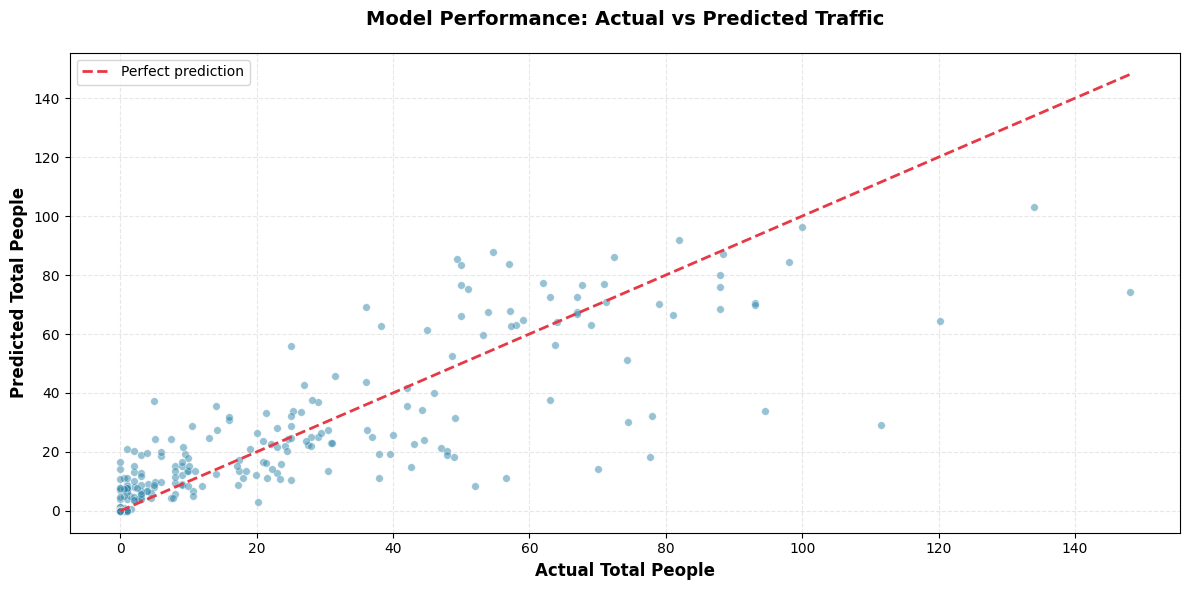

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred, alpha=0.5, s=30, color='#2E86AB', edgecolors='white', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], "--", color='#E63946', linewidth=2, label='Perfect prediction')
plt.xlabel("Actual Total People", fontsize=12, fontweight='bold')
plt.ylabel("Predicted Total People", fontsize=12, fontweight='bold')
plt.title("Model Performance: Actual vs Predicted Traffic", fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [10]:
import numpy as np

importances = rf.feature_importances_
for name, val in sorted(zip(X.columns, importances),
                        key=lambda x: x[1], reverse=True):
    print(f"{name}: {val:.3f}")


hour: 0.443
street_code: 0.194
temperature_c: 0.084
dayofweek: 0.073
wind_speed_kmh: 0.070
is_school_vacation: 0.070
is_weekend: 0.032
cloud_cover_pct: 0.024
precipitation_mm: 0.008
is_holiday: 0.002


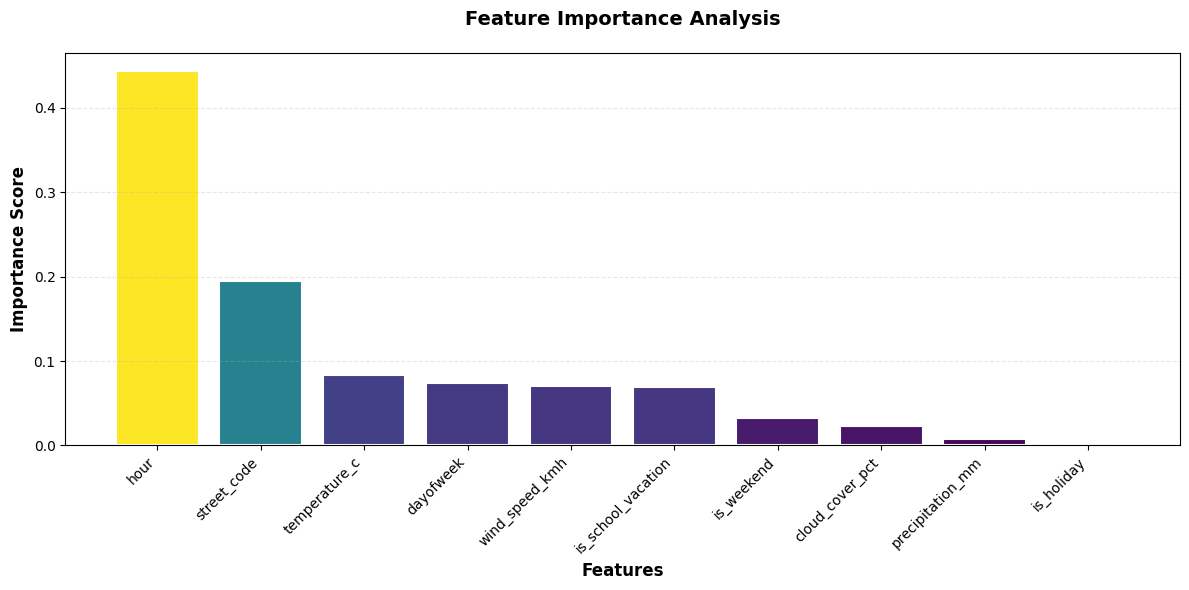

In [11]:
plt.figure(figsize=(12,6))
idx = np.argsort(importances)[::-1]
colors = plt.cm.viridis(importances[idx] / importances[idx].max())
plt.bar(range(len(idx)), importances[idx], color=colors, edgecolor='white', linewidth=1.5)
plt.xticks(range(len(idx)), X.columns[idx], rotation=45, ha="right", fontsize=10)
plt.xlabel("Features", fontsize=12, fontweight='bold')
plt.ylabel("Importance Score", fontsize=12, fontweight='bold')
plt.title("Feature Importance Analysis", fontsize=14, fontweight='bold', pad=20)

plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()

plt.show()

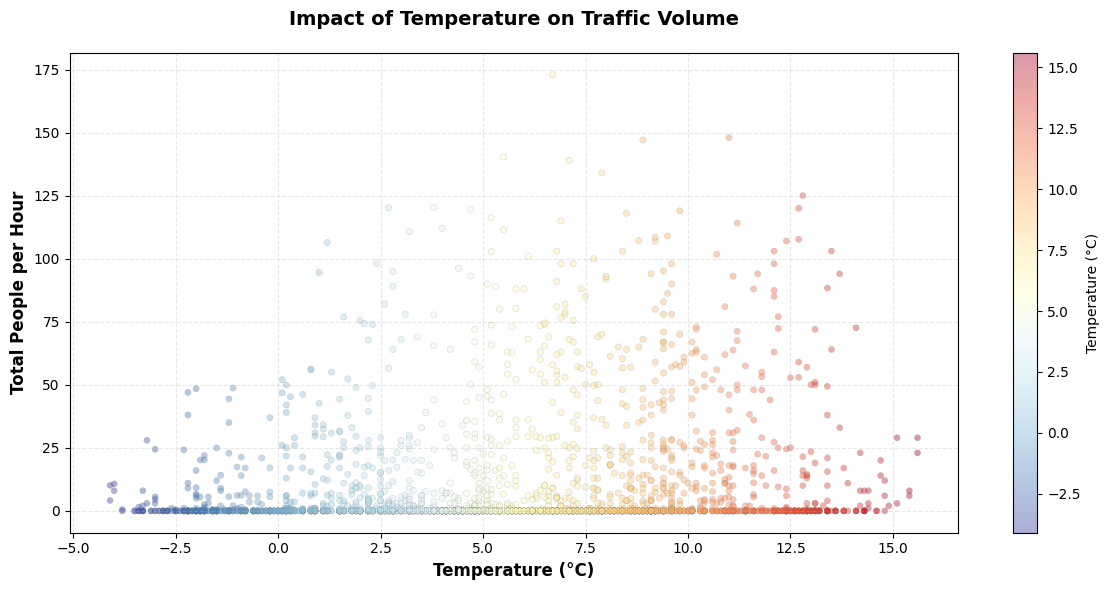

In [12]:
plt.figure(figsize=(12,6))
plt.scatter(df_model["temperature_c"], df_model["total_people"], 
           alpha=0.4, s=20, c=df_model["temperature_c"], cmap='RdYlBu_r', edgecolors='gray', linewidth=0.3)
cbar = plt.colorbar(label='Temperature (°C)')
plt.xlabel("Temperature (°C)", fontsize=12, fontweight='bold')
plt.ylabel("Total People per Hour", fontsize=12, fontweight='bold')
plt.title("Impact of Temperature on Traffic Volume", fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()

plt.show()

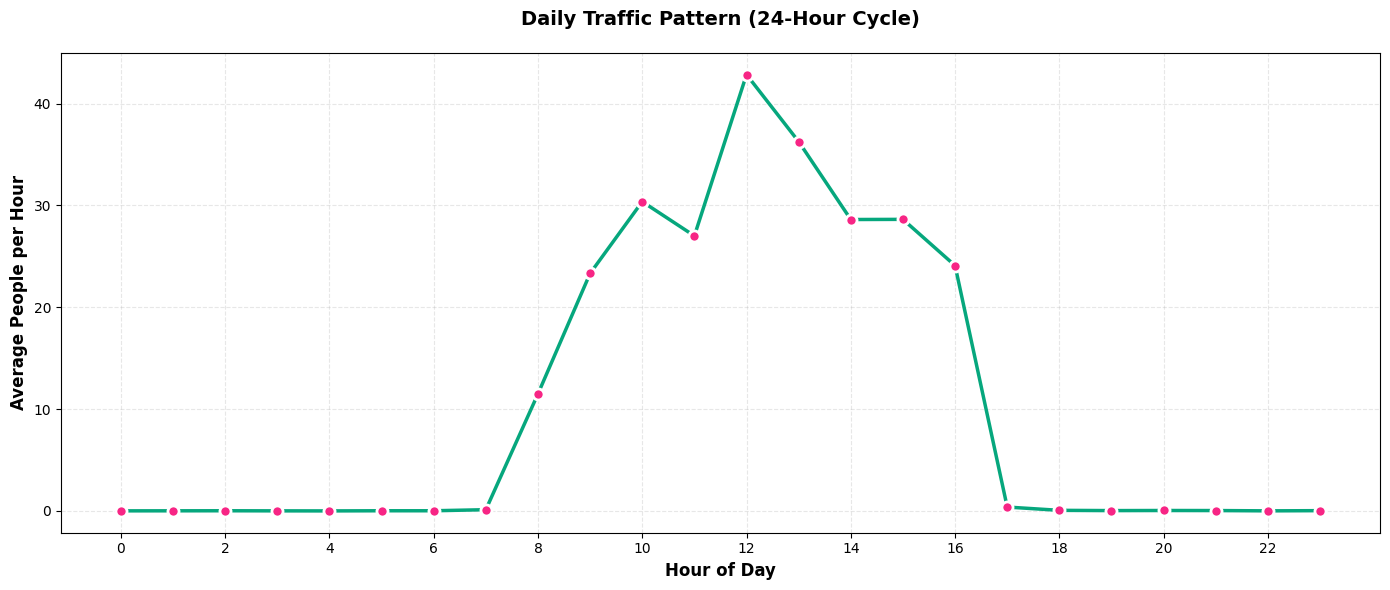

In [13]:
avg_by_hour = df_model.groupby("hour")["total_people"].mean()

plt.figure(figsize=(14,6))
plt.plot(avg_by_hour.index, avg_by_hour.values, marker="o", linewidth=2.5, 
        markersize=8, color='#06A77D', markerfacecolor='#F72585', 
        markeredgecolor='white', markeredgewidth=2)
plt.xlabel("Hour of Day", fontsize=12, fontweight='bold')
plt.ylabel("Average People per Hour", fontsize=12, fontweight='bold')
plt.title("Daily Traffic Pattern (24-Hour Cycle)", fontsize=14, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')

plt.xticks(range(0, 24, 2))

plt.tight_layout()

plt.show()

In [14]:
avg_by_group = df_model.groupby(
    ["is_holiday", "is_school_vacation"]
)["total_people"].mean().reset_index()

print(avg_by_group)


   is_holiday  is_school_vacation  total_people
0           0                   0     12.300020
1           0                   1      6.990931
2           1                   0      4.291667
3           1                   1      3.040411


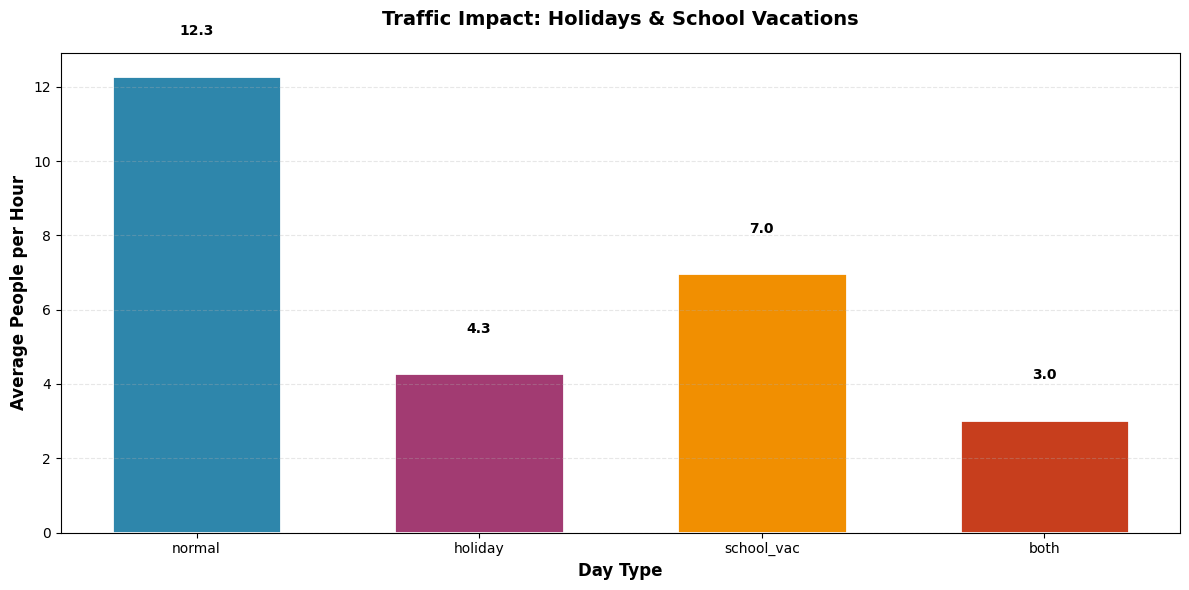

In [15]:
labels = ["normal", "holiday", "school_vac", "both"]
avg_vals = []

for h, v in [(0,0), (1,0), (0,1), (1,1)]:
    avg_vals.append(
        df_model[
            (df_model["is_holiday"] == h) &
            (df_model["is_school_vacation"] == v)
        ]["total_people"].mean()
    )

plt.figure(figsize=(12,6))

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
plt.bar(labels, avg_vals,
        color=colors,
        edgecolor='white',
        linewidth=2,
        width=0.6)

plt.ylabel("Average People per Hour", fontsize=12, fontweight='bold')
plt.xlabel("Day Type", fontsize=12, fontweight='bold')
plt.title("Traffic Impact: Holidays & School Vacations",
          fontsize=14, fontweight='bold', pad=20)

plt.grid(axis='y', alpha=0.3, linestyle='--')

# ✅ labels MUST be inside loop
for i, v in enumerate(avg_vals):
    plt.text(
        i, v + 1,
        f'{v:.1f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10
    )

plt.tight_layout()
plt.show()


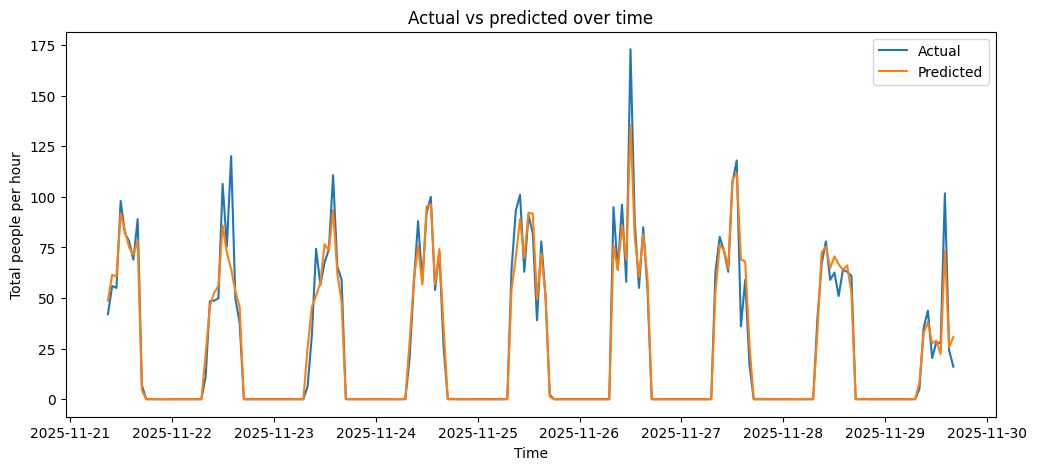

In [16]:
sample = df_model.iloc[:200].copy()
sample_X = sample[feature_cols]
sample["pred_total"] = rf.predict(sample_X)

plt.figure(figsize=(12,5))
plt.plot(sample["datetime"], sample["total_people"], label="Actual")
plt.plot(sample["datetime"], sample["pred_total"], label="Predicted")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Total people per hour")
plt.title("Actual vs predicted over time")
plt.show()


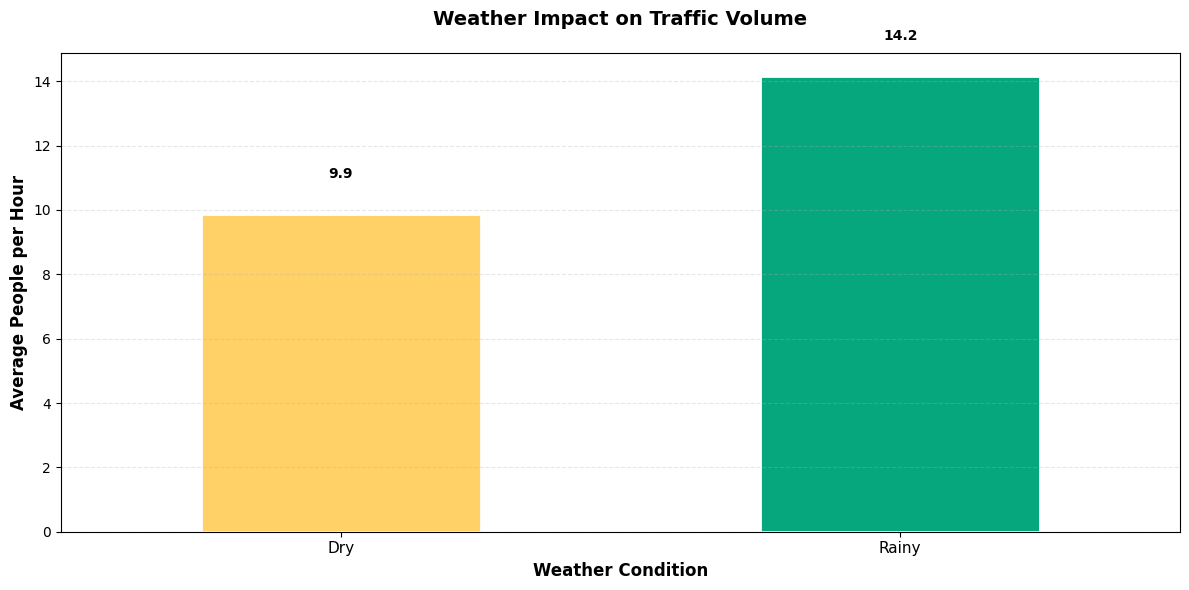

In [17]:
df_model["is_rain"] = (df_model["precipitation_mm"] > 0).astype(int)
avg_rain = df_model.groupby("is_rain")["total_people"].mean()

plt.figure(figsize=(12,6))

colors = ['#FFD166', '#06A77D']
avg_rain.plot(
    kind="bar",
    rot=0,
    color=colors,
    edgecolor='white',
    linewidth=2,
    width=0.5
)

plt.xticks([0, 1], ["Dry", "Rainy"], fontsize=11)
plt.ylabel("Average People per Hour", fontsize=12, fontweight='bold')
plt.xlabel("Weather Condition", fontsize=12, fontweight='bold')
plt.title("Weather Impact on Traffic Volume",
          fontsize=14, fontweight='bold', pad=20)

plt.grid(axis='y', alpha=0.3, linestyle='--')

# ✅ ADD LABELS BEFORE show()
for i, v in enumerate(avg_rain.values):
    plt.text(
        i, v + 1,
        f'{v:.1f}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10
    )

plt.tight_layout()
plt.show()


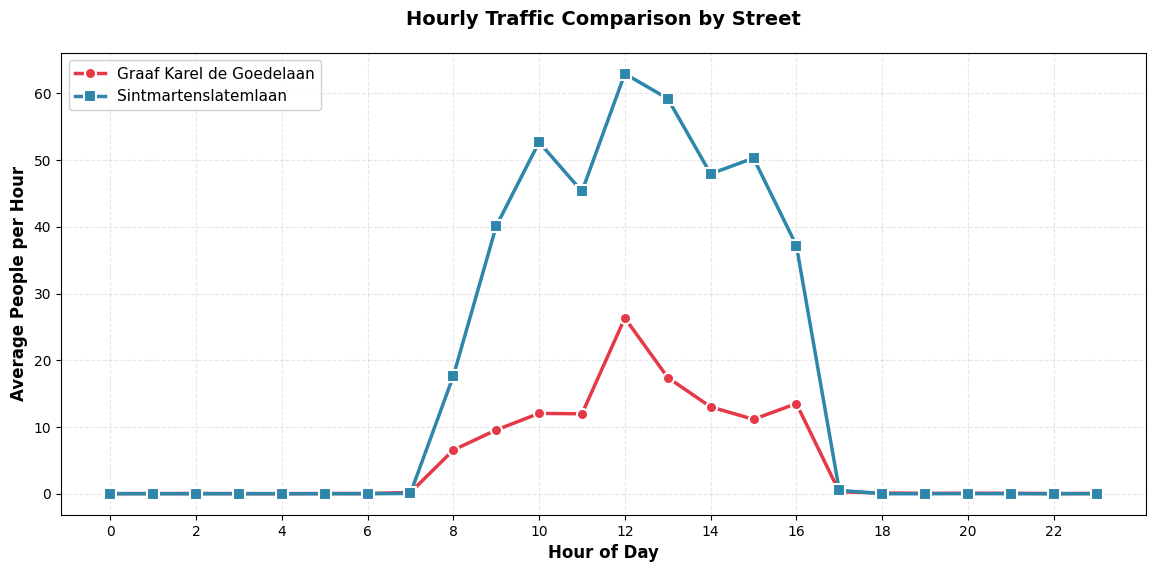

<Figure size 640x480 with 0 Axes>

In [18]:
avg_by_hour_street = df_model.groupby(["street_name", "hour"])["total_people"].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
colors = ['#E63946', '#2E86AB']
markers = ['o', 's']
for (street, group), color, marker in zip(avg_by_hour_street.groupby("street_name"), colors, markers):
    plt.plot(group["hour"], group["total_people"], marker=marker, label=street, 
            linewidth=2.5, markersize=8, color=color, markeredgecolor='white', markeredgewidth=1.5)

plt.xlabel("Hour of Day", fontsize=12, fontweight='bold')
plt.ylabel("Average People per Hour", fontsize=12, fontweight='bold')
plt.title("Hourly Traffic Comparison by Street", fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='upper left', framealpha=0.9)

plt.grid(True, alpha=0.3, linestyle='--')

plt.xticks(range(0, 24, 2))
plt.show()
plt.tight_layout()

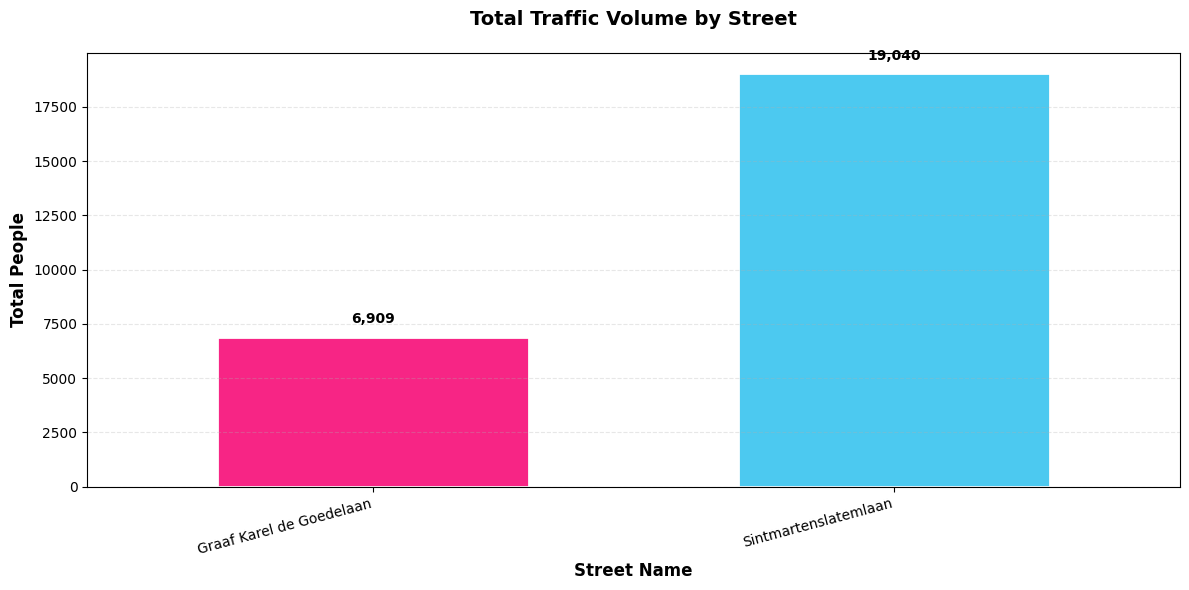

In [19]:
plt.figure(figsize=(12,6))

total_per_street = df_model.groupby("street_name")["total_people"].sum()

colors = ['#F72585', '#4CC9F0']
total_per_street.plot(
    kind="bar",
    color=colors,
    edgecolor='white',
    linewidth=2,
    width=0.6
)

plt.xticks(rotation=15, ha='right', fontsize=10)
plt.ylabel("Total People", fontsize=12, fontweight='bold')
plt.xlabel("Street Name", fontsize=12, fontweight='bold')
plt.title("Total Traffic Volume by Street",
          fontsize=14, fontweight='bold', pad=20)

plt.grid(axis='y', alpha=0.3, linestyle='--')

# ✅ ADD LABELS BEFORE show()
for i, v in enumerate(total_per_street.values):
    plt.text(
        i,
        v + 500,
        f'{int(v):,}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10
    )

plt.tight_layout()
plt.show()


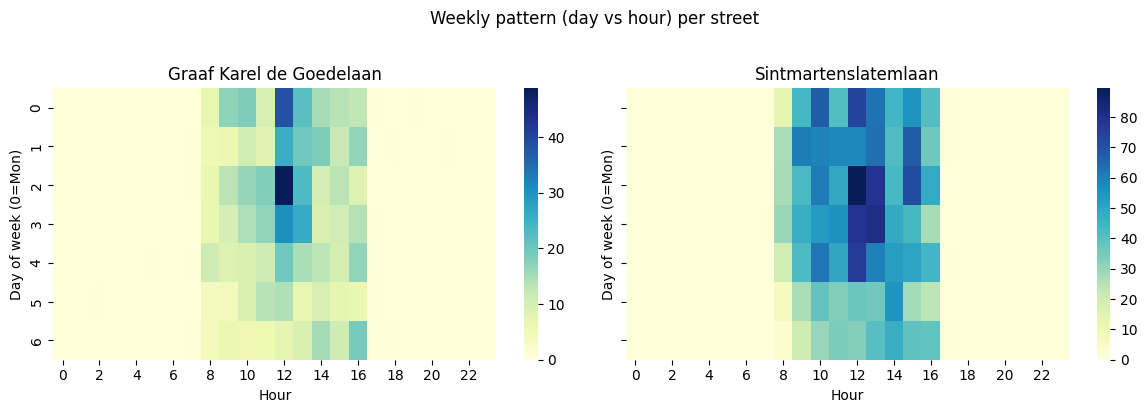

In [20]:
# average per day-of-week and hour, for each street
pivot = (
    df_model.groupby(["street_name","dayofweek","hour"])["total_people"]
    .mean()
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

for ax, (street, sub) in zip(axes, pivot.groupby("street_name")):
    table = sub.pivot(index="dayofweek", columns="hour", values="total_people")
    sns.heatmap(table, ax=ax, cmap="YlGnBu")
    ax.set_title(street)
    ax.set_xlabel("Hour")
    ax.set_ylabel("Day of week (0=Mon)")

fig.suptitle("Weekly pattern (day vs hour) per street", y=1.02)
plt.tight_layout()
plt.show()


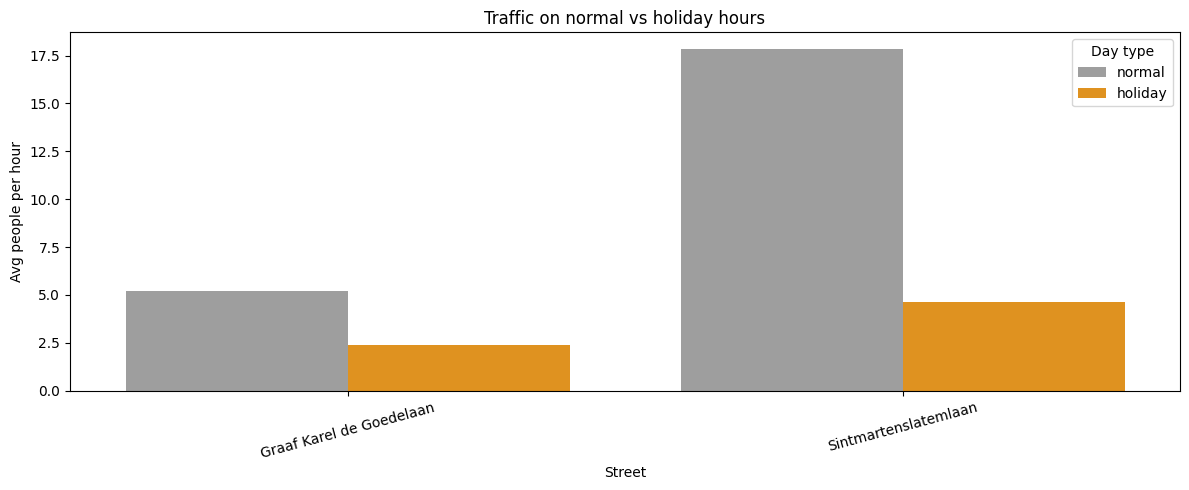

In [21]:
avg_holiday = (
    df_model.groupby(["street_name","is_holiday"])["total_people"]
    .mean()
    .reset_index()
)


plt.figure(figsize=(12,5))
sns.barplot(
    data=avg_holiday,
    x="street_name",
    y="total_people",
    hue="is_holiday",
    palette=["#9E9E9E","#FF9800"]
)
plt.xticks(rotation=15)
plt.xlabel("Street")
plt.ylabel("Avg people per hour")
plt.title("Traffic on normal vs holiday hours")

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["normal", "holiday"], title="Day type")
plt.tight_layout()
plt.show()



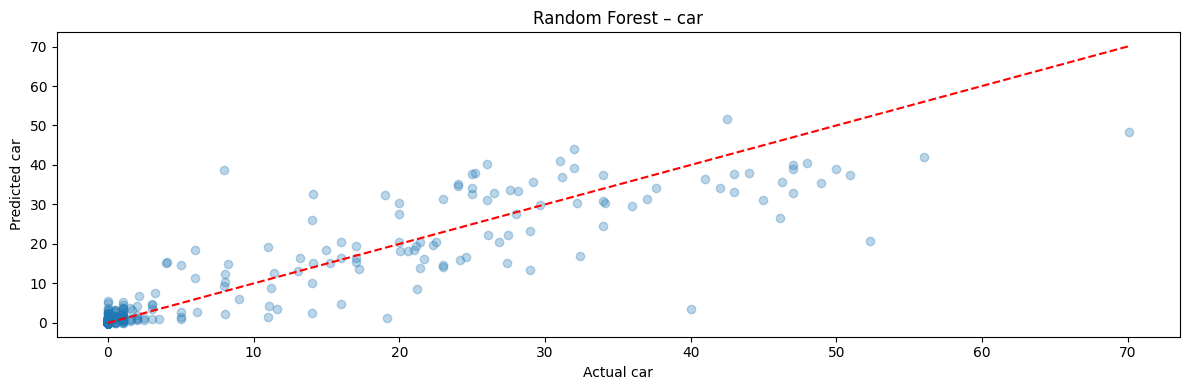

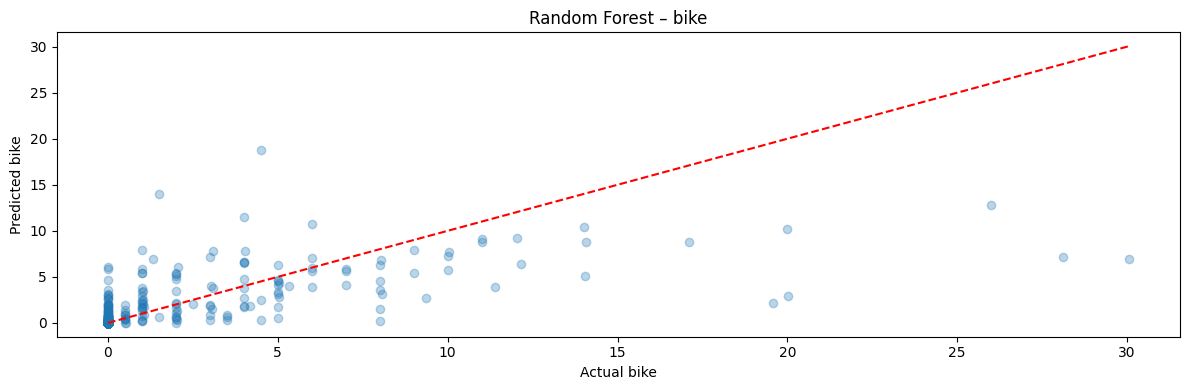

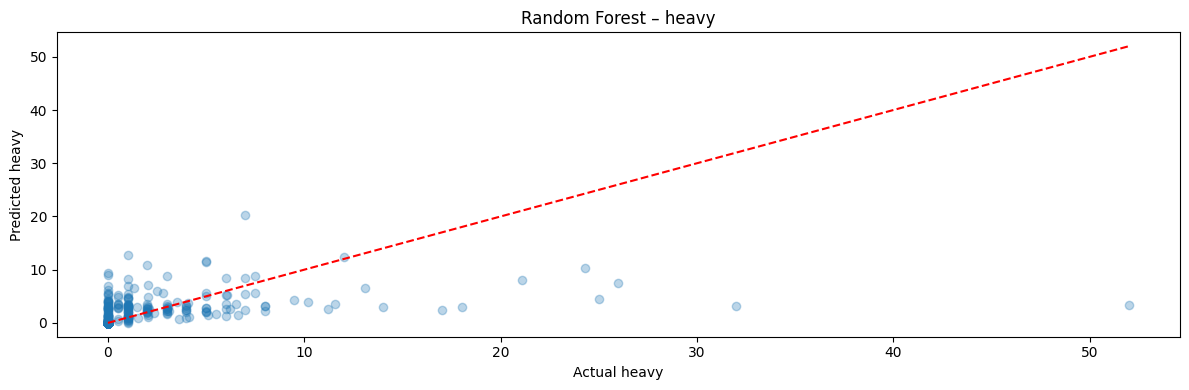

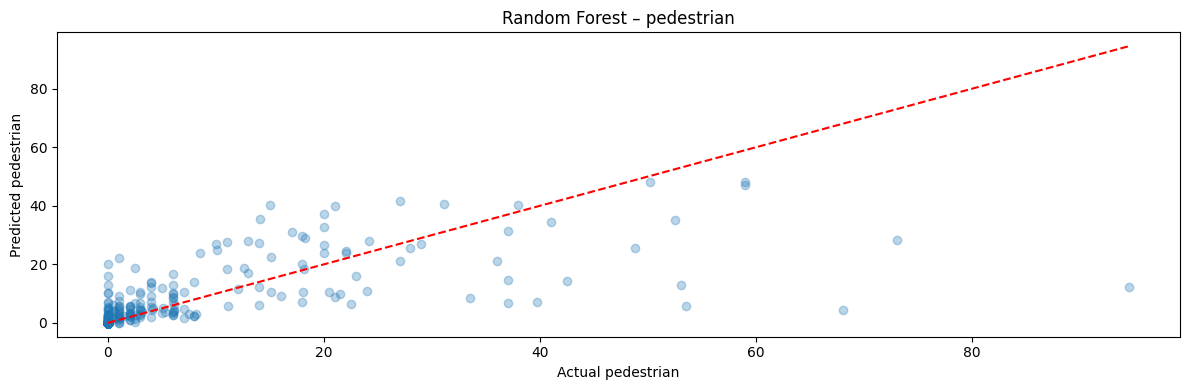

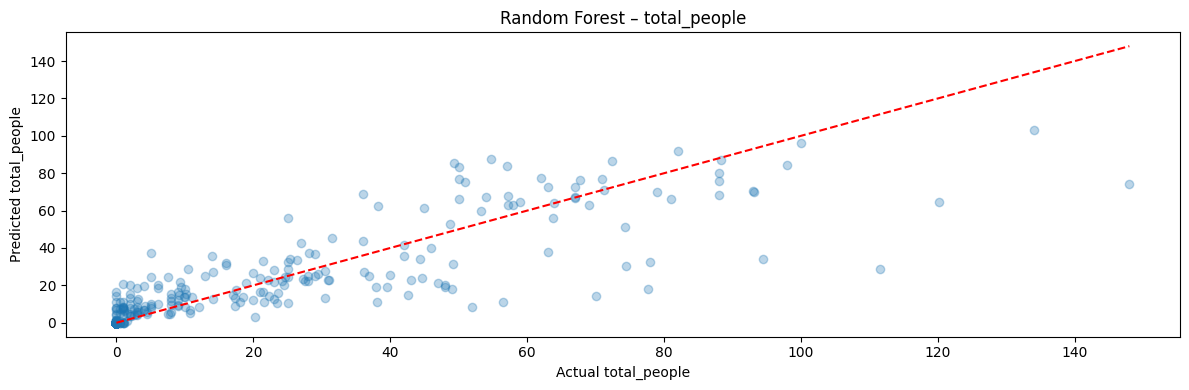

In [22]:
for t in targets:
    rf = models[t]
    y = df_model[t]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    y_pred = rf.predict(X_test)

    plt.figure(figsize=(12,4))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], "r--")
    plt.xlabel(f"Actual {t}")
    plt.ylabel(f"Predicted {t}")
    plt.title(f"Random Forest – {t}")
    plt.tight_layout()
    plt.show()


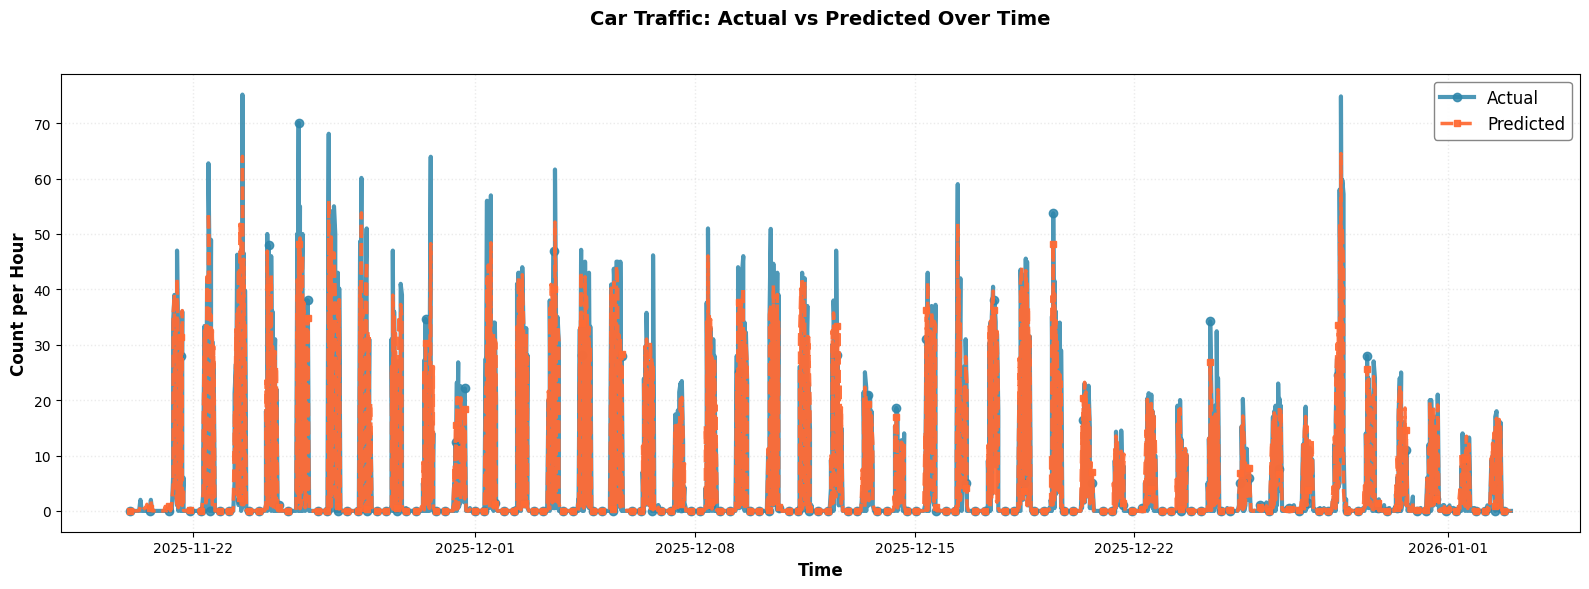

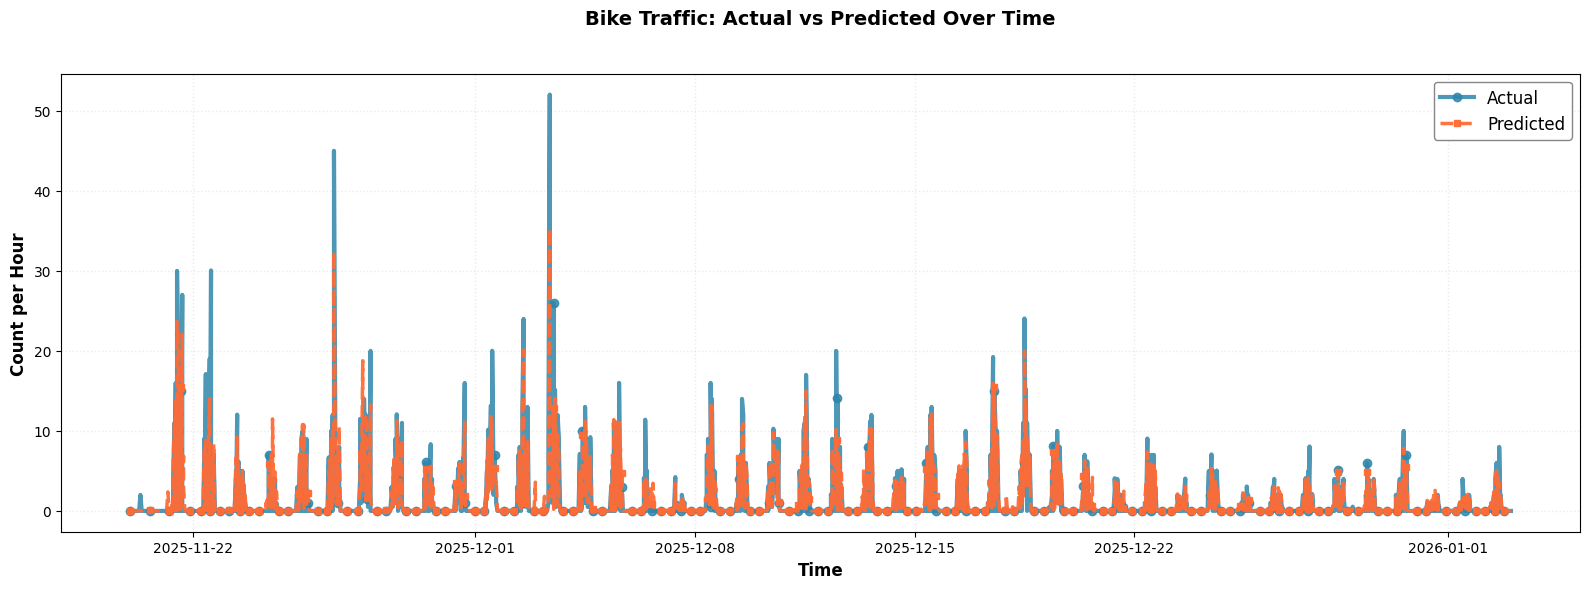

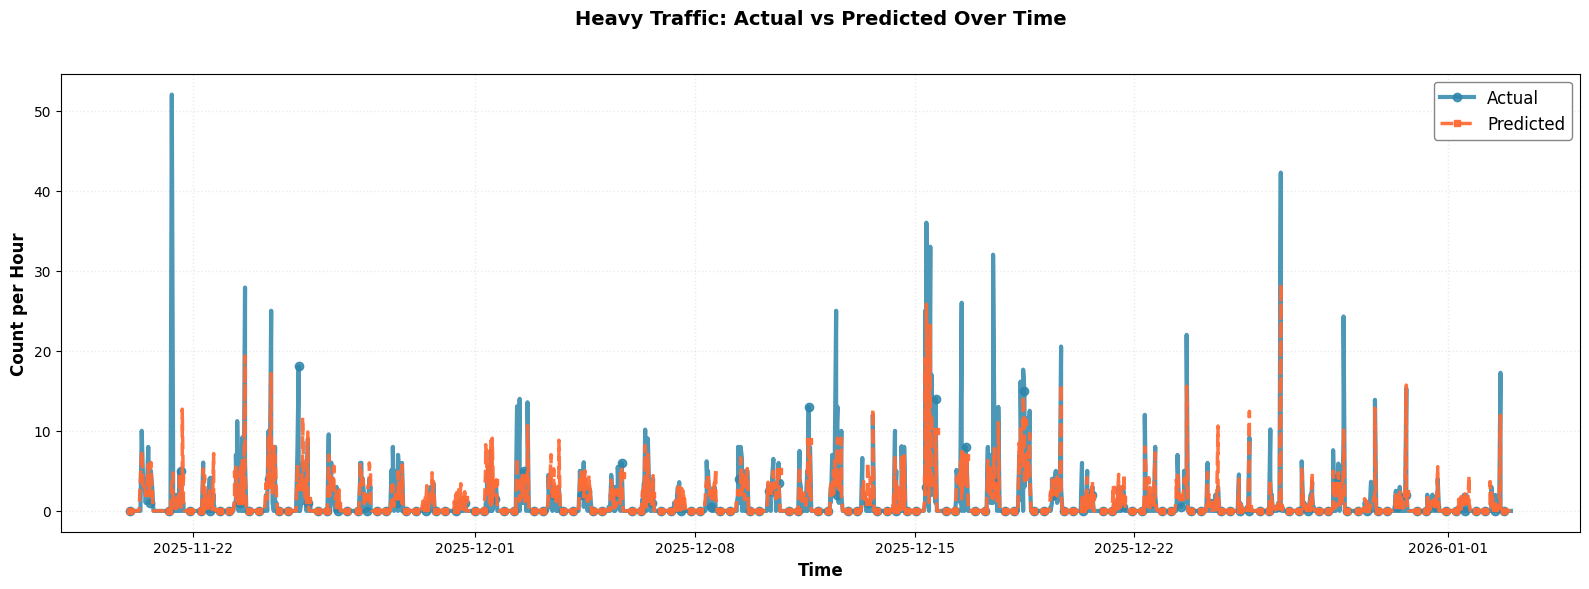

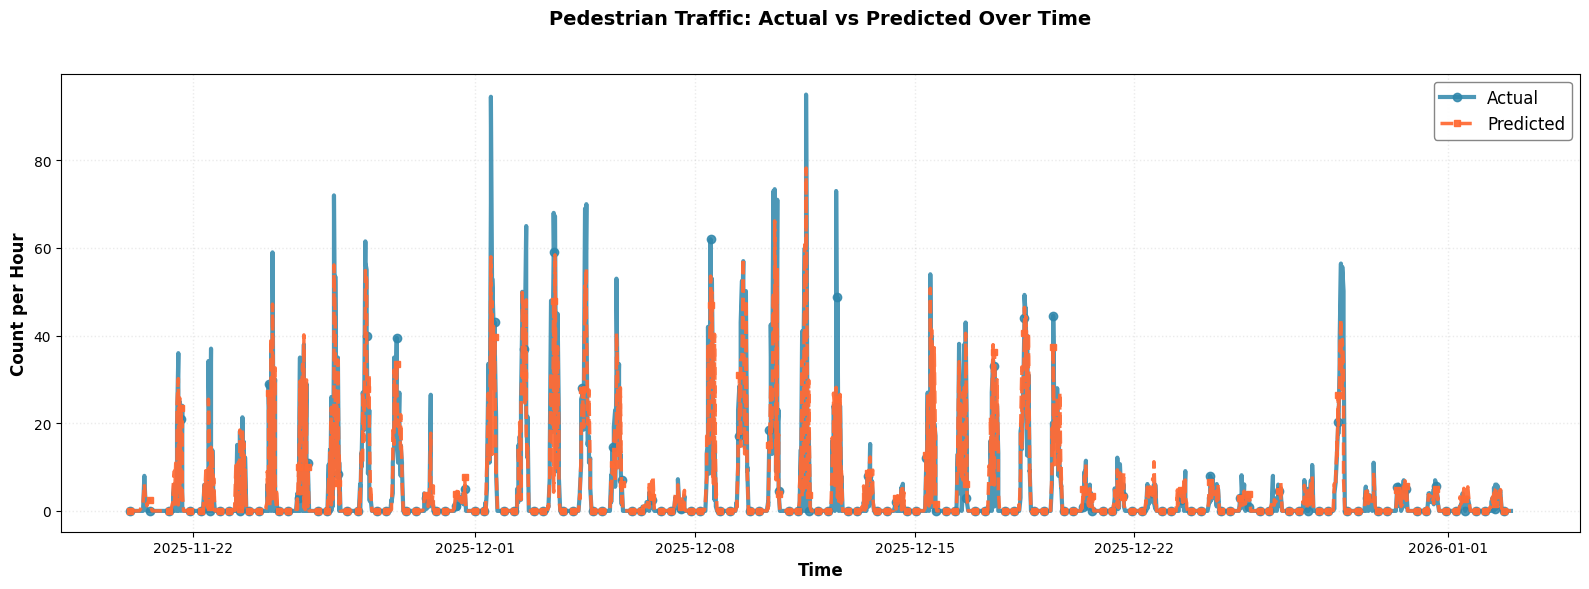

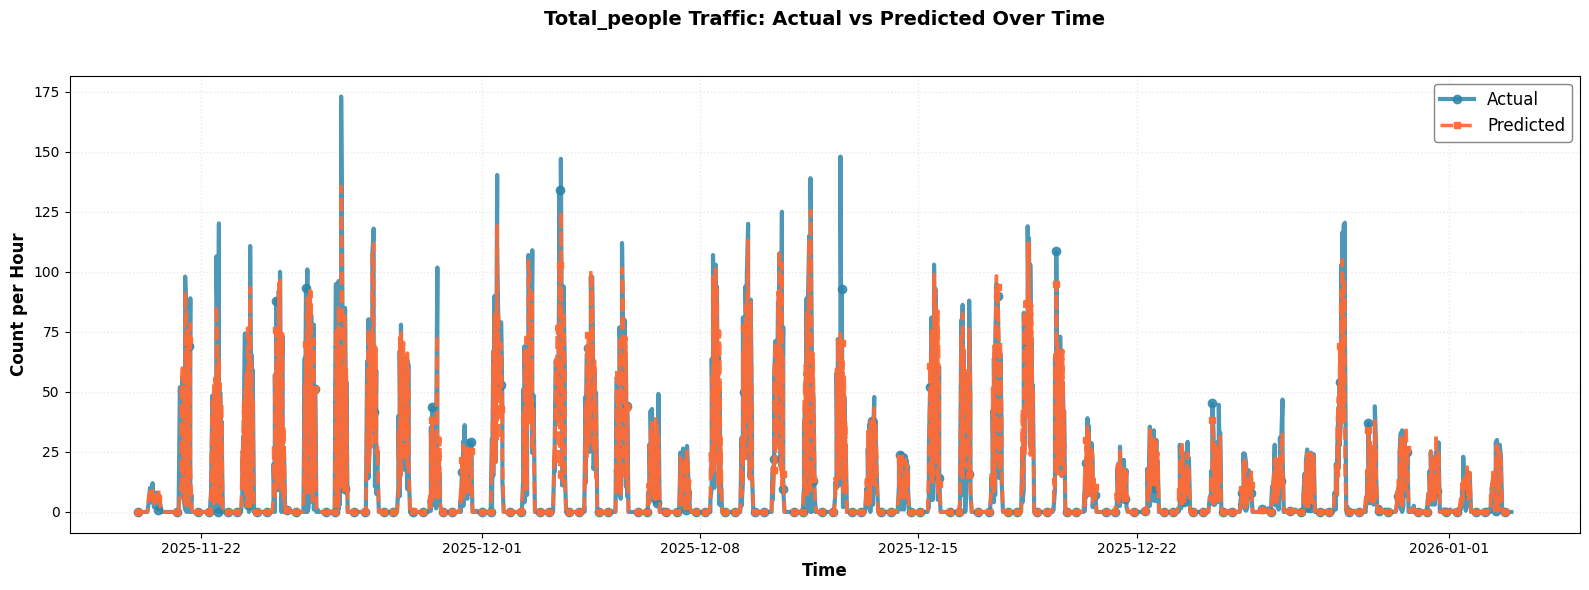

In [23]:
# sample = df_model.sort_values("datetime").iloc[100:1200].copy()

sample = df_model.sort_values("datetime")
start = "2025-11-20"
end   = "2026-01-03"

mask = (sample["datetime"] >= start) & (sample["datetime"] <= end)
sample = sample.loc[mask].copy()


for t in targets:
    rf = models[t]
    sample[f"pred_{t}"] = rf.predict(sample[feature_cols])

    plt.figure(figsize=(16,6))
    
    # Plot actual with solid line and circles
    plt.plot(sample["datetime"], sample[t], label="Actual", 
            linewidth=3, color='#2E86AB', marker='o', markersize=6, 
            markevery=15, alpha=0.85, zorder=2)
    
    # Plot predicted with dashed line and different color
    plt.plot(sample["datetime"], sample[f"pred_{t}"], label="Predicted", 
            linewidth=2.5, color='#FF6B35', linestyle='--', marker='s', 
            markersize=5, markevery=15, alpha=0.95, zorder=3)
    
    plt.xlabel("Time", fontsize=12, fontweight='bold')
    plt.ylabel("Count per Hour", fontsize=12, fontweight='bold')
    plt.title(f"{t.capitalize()} Traffic: Actual vs Predicted Over Time\n", 
             fontsize=14, fontweight='bold', pad=20)
    plt.legend(fontsize=12, loc='best', framealpha=0.95, edgecolor='gray', fancybox=True)
    plt.grid(True, alpha=0.25, linestyle=':', linewidth=1)
    
    plt.tight_layout()
    plt.show()


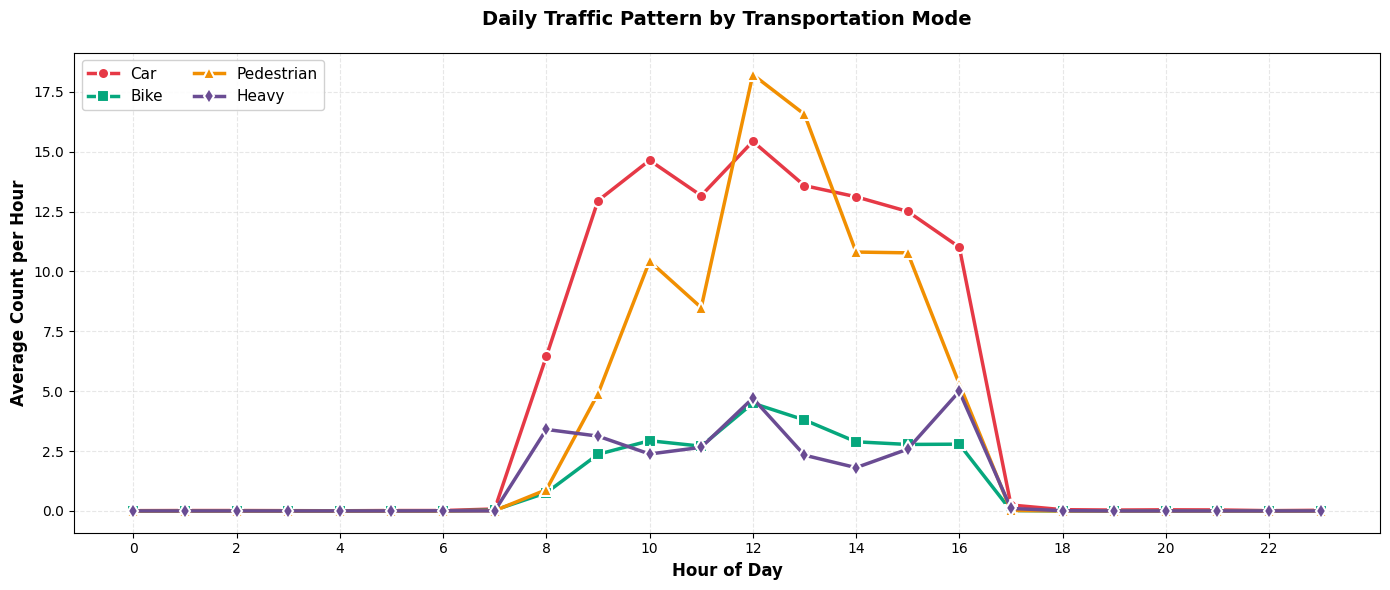

In [24]:
avg_hour_mode = df_model.groupby("hour")[["car", "bike", "pedestrian", "heavy"]].mean()

plt.figure(figsize=(14,6))

colors = {
    'car': '#E63946',
    'bike': '#06A77D',
    'pedestrian': '#F18F01',
    'heavy': '#6A4C93'
}
markers = {
    'car': 'o',
    'bike': 's',
    'pedestrian': '^',
    'heavy': 'd'
}

modes = ["car", "bike", "pedestrian", "heavy"]  # ✅ define modes

for m in modes:
    plt.plot(
        avg_hour_mode.index,
        avg_hour_mode[m],
        marker=markers[m],
        label=m.capitalize(),
        linewidth=2.5,
        markersize=8,
        color=colors[m],
        markeredgecolor='white',
        markeredgewidth=1.5
    )

plt.xlabel("Hour of Day", fontsize=12, fontweight='bold')
plt.ylabel("Average Count per Hour", fontsize=12, fontweight='bold')
plt.title("Daily Traffic Pattern by Transportation Mode",
          fontsize=14, fontweight='bold', pad=20)

plt.xticks(range(0, 24, 2))  # ✅ before show
plt.legend(fontsize=11, loc='upper left', framealpha=0.9, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


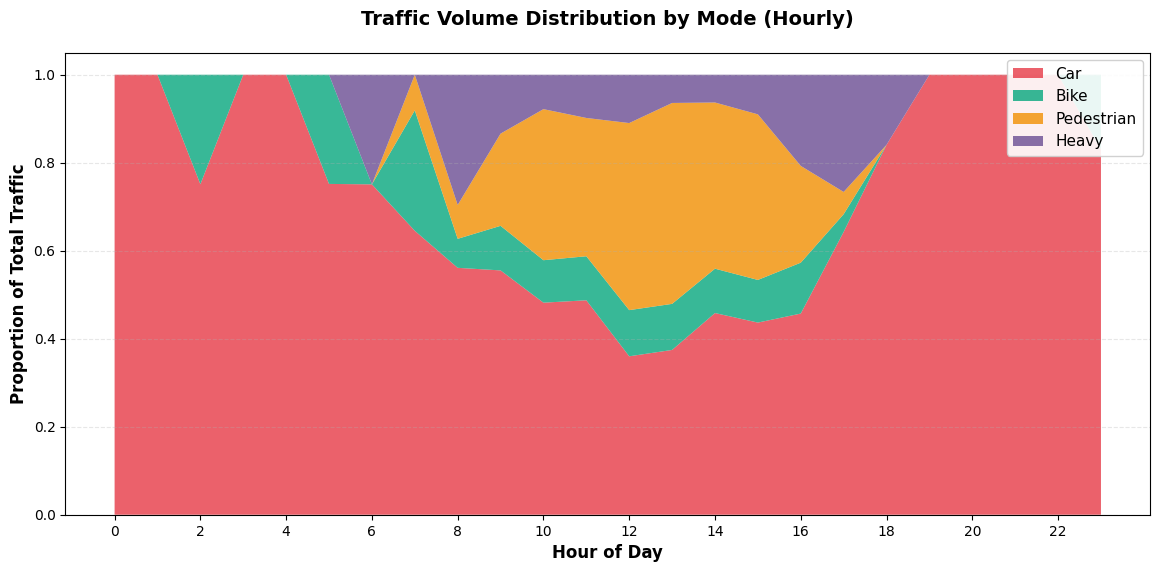

<Figure size 640x480 with 0 Axes>

In [25]:
share = avg_hour_mode.div(avg_hour_mode.sum(axis=1), axis=0)

plt.figure(figsize=(14,6))
colors = ['#E63946', '#06A77D', '#F18F01', '#6A4C93']
plt.stackplot(
    share.index,
    [share[m] for m in modes],
    labels=[m.capitalize() for m in modes],
    colors=colors,
    alpha=0.8
)
plt.xlabel("Hour of Day", fontsize=12, fontweight='bold')
plt.ylabel("Proportion of Total Traffic", fontsize=12, fontweight='bold')
plt.title("Traffic Volume Distribution by Mode (Hourly)", fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="upper right", fontsize=11, framealpha=0.9)

plt.grid(axis='y', alpha=0.3, linestyle='--')

plt.xticks(range(0, 24, 2))
plt.show()
plt.tight_layout()

## Volume Analysis by Mode

Detailed analysis of traffic volume distribution across different transportation modes.

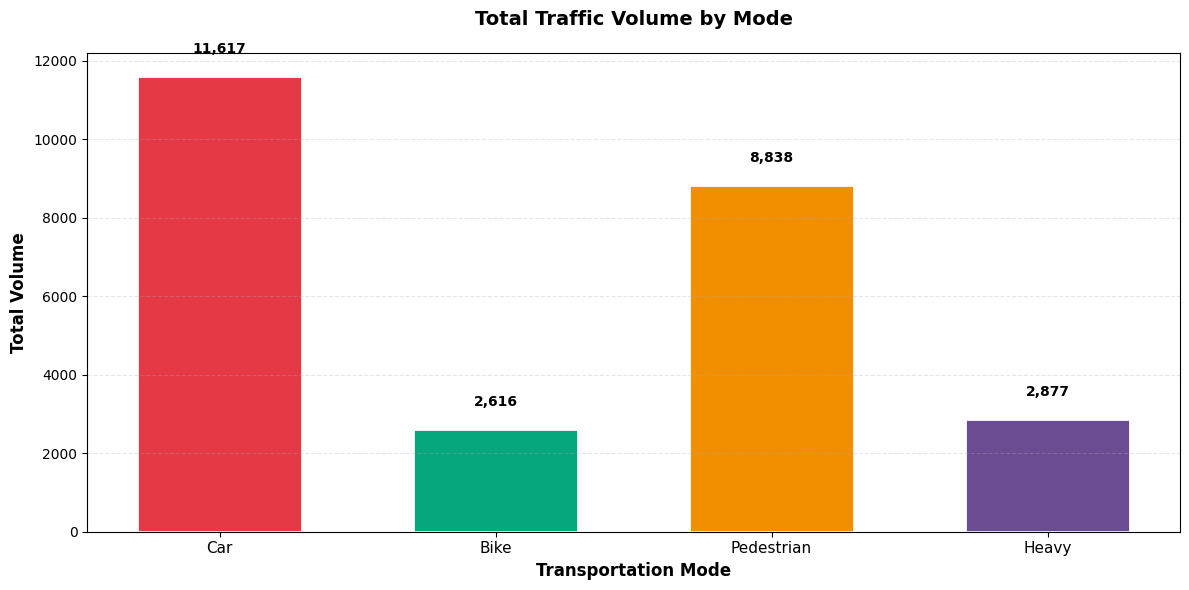

In [26]:
# Total volume by mode
total_volume = df_model[modes].sum()

plt.figure(figsize=(12,6))
colors = ['#E63946', '#06A77D', '#F18F01', '#6A4C93']
bars = plt.bar(range(len(modes)), total_volume, color=colors, edgecolor='white', linewidth=2, width=0.6)
plt.xticks(range(len(modes)), [m.capitalize() for m in modes], fontsize=11)
plt.ylabel("Total Volume", fontsize=12, fontweight='bold')
plt.xlabel("Transportation Mode", fontsize=12, fontweight='bold')
plt.title("Total Traffic Volume by Mode", fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, total_volume)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 500, f'{int(val):,}', 
            ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

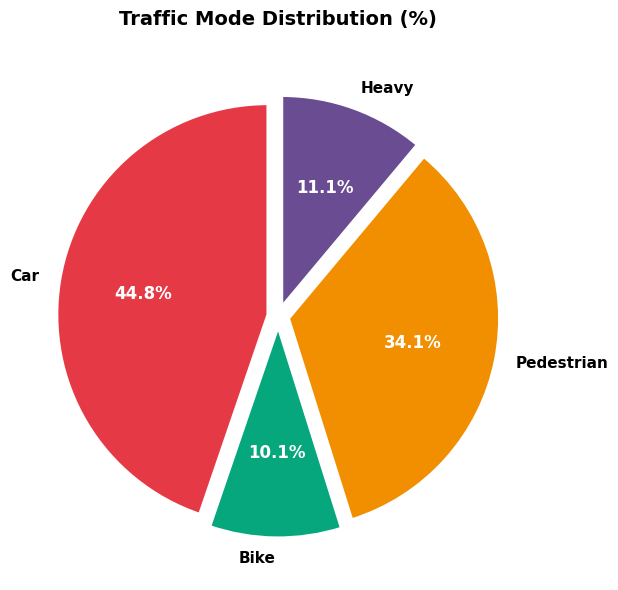

In [27]:
# Percentage share of each mode
mode_percentages = (total_volume / total_volume.sum() * 100).round(1)

plt.figure(figsize=(12,6))

colors = ['#E63946', '#06A77D', '#F18F01', '#6A4C93']

wedges, texts, autotexts = plt.pie(
    mode_percentages,
    labels=[m.capitalize() for m in modes],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    explode=(0.05, 0.05, 0.05, 0.05),
    textprops={'fontsize': 11, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Set text color for percentages
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    
plt.title("Traffic Mode Distribution (%)", fontsize=14, fontweight='bold', pad=20)  # ✅ fixed string

plt.tight_layout()
plt.show()


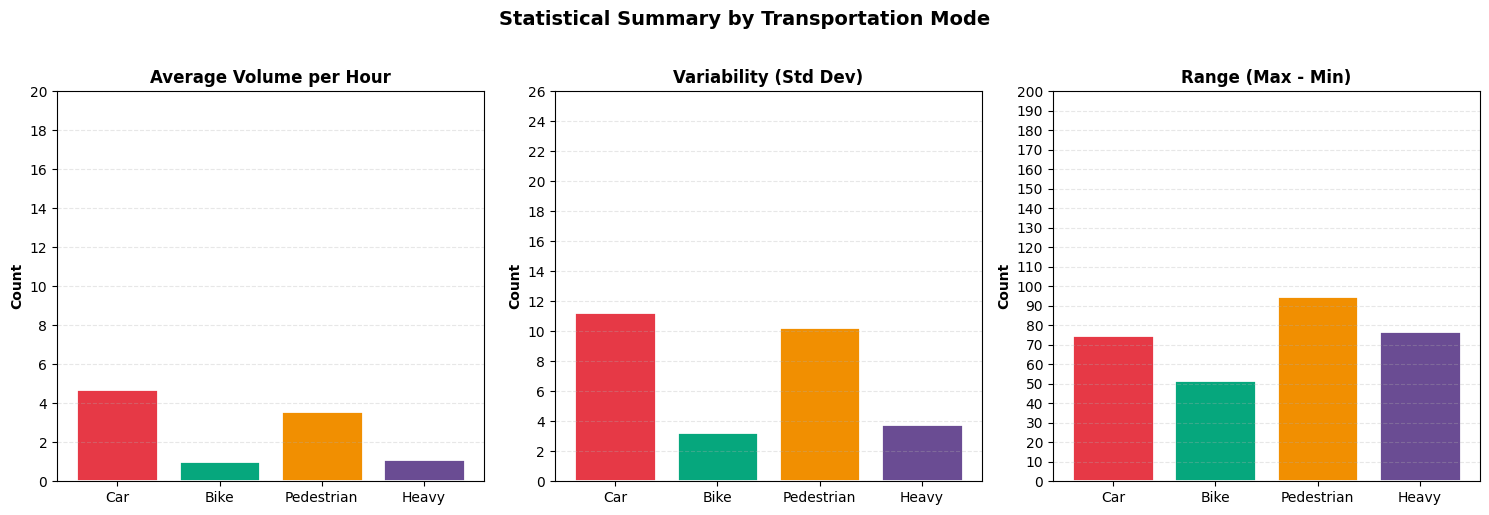

In [28]:
# Volume statistics by mode
volume_stats = df_model[modes].agg(['mean', 'std', 'min', 'max']).T

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#E63946', '#06A77D', '#F18F01', '#6A4C93']

# Mean
axes[0].bar(range(1, len(modes)+1), volume_stats['mean'], color=colors, edgecolor='white', linewidth=2)
axes[0].set_xticks(range(1, len(modes)+1))
axes[0].set_xticklabels([m.capitalize() for m in modes])
axes[0].set_title('Average Volume per Hour', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].set_yticks([0, 2, 4, 6, 8,10,12,14,16,18,20])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Standard Deviation
axes[1].bar(range(1, len(modes)+1), volume_stats['std'], color=colors, edgecolor='white', linewidth=2)
axes[1].set_xticks(range(1, len(modes)+1))
axes[1].set_xticklabels([m.capitalize() for m in modes])
axes[1].set_title('Variability (Std Dev)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_yticks([0, 2, 4, 6, 8, 10,12,14,16,18,20 ,22,24,26])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Range (Max - Min)
volume_range = volume_stats['max'] - volume_stats['min']
axes[2].bar(range(1, len(modes)+1), volume_range, color=colors, edgecolor='white', linewidth=2)
axes[2].set_xticks(range(1, len(modes)+1))
axes[2].set_xticklabels([m.capitalize() for m in modes])
axes[2].set_title('Range (Max - Min)', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Count', fontweight='bold')
axes[2].set_yticks([0, 10, 20, 30, 40,50,60,70,80,90, 100 , 110, 120,  130, 140 ,150 ,160,170,180,190,200])
axes[2].grid(axis='y', alpha=0.3, linestyle='--')

fig.suptitle('Statistical Summary by Transportation Mode', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

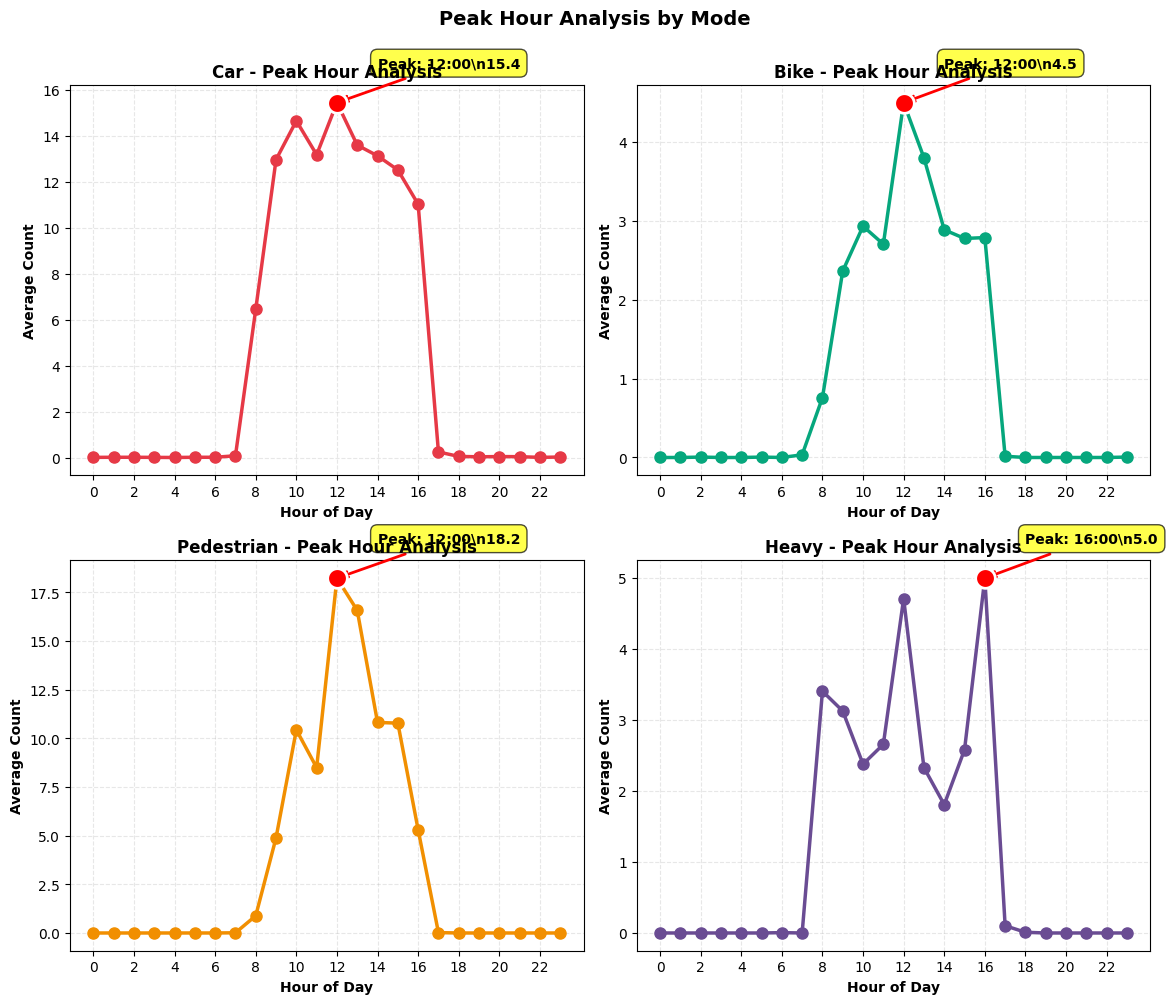

In [29]:
# Peak hours for each mode
peak_hours = {}
for m in modes:
    hourly_avg = df_model.groupby('hour')[m].mean()
    peak_hour = hourly_avg.idxmax()
    peak_value = hourly_avg.max()
    peak_hours[m] = {'hour': peak_hour, 'value': peak_value}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()
colors = ['#E63946', '#06A77D', '#F18F01', '#6A4C93']

for idx, m in enumerate(modes):
    hourly_avg = df_model.groupby('hour')[m].mean()
    axes[idx].plot(hourly_avg.index, hourly_avg.values, linewidth=2.5, color=colors[idx], marker='o', markersize=8)
    
    # Highlight peak hour
    peak_h = peak_hours[m]['hour']
    peak_v = peak_hours[m]['value']
    axes[idx].scatter([peak_h], [peak_v], color='red', s=200, zorder=5, edgecolors='white', linewidth=2)
    axes[idx].annotate(f'Peak: {peak_h}:00\\n{peak_v:.1f}', 
                      xy=(peak_h, peak_v), xytext=(peak_h+2, peak_v*1.1),
                      fontsize=10, fontweight='bold',
                      bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                      arrowprops=dict(arrowstyle='->', color='red', lw=2))
    
    axes[idx].set_xlabel('Hour of Day', fontweight='bold')
    axes[idx].set_ylabel('Average Count', fontweight='bold')
    axes[idx].set_title(f'{m.capitalize()} - Peak Hour Analysis', fontweight='bold', fontsize=12)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].set_xticks(range(0, 24, 2))

fig.suptitle('Peak Hour Analysis by Mode', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

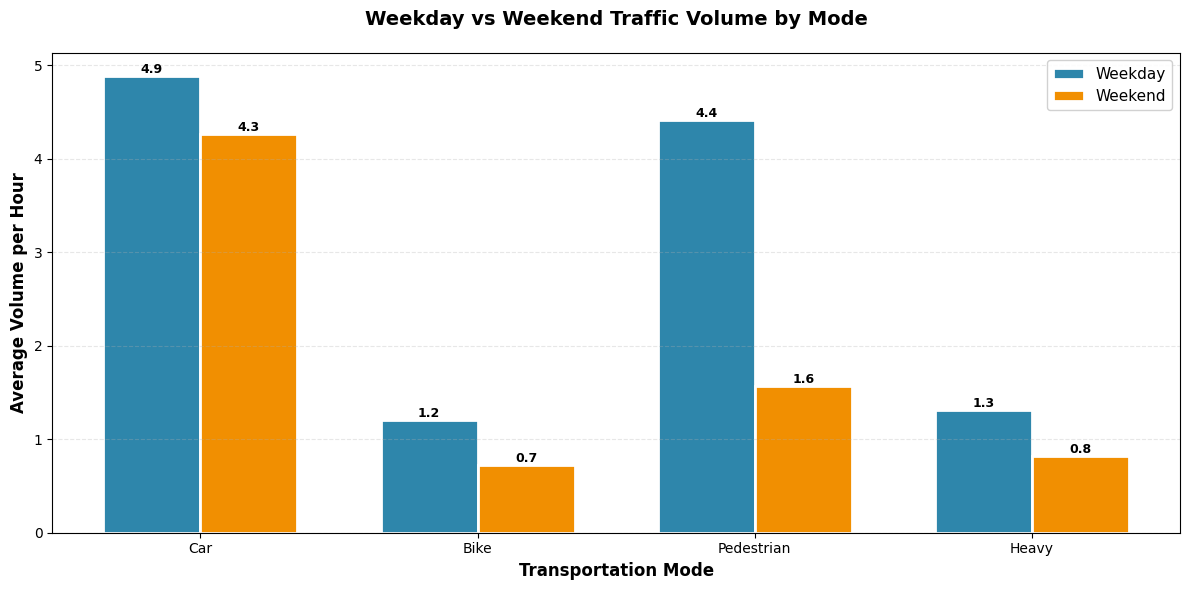

In [30]:
# Weekend vs Weekday volume comparison
weekend_avg = df_model[df_model['is_weekend']==1][modes].mean()
weekday_avg = df_model[df_model['is_weekend']==0][modes].mean()

x = np.arange(len(modes))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, weekday_avg, width, label='Weekday', 
              color='#2E86AB', edgecolor='white', linewidth=2)
bars2 = ax.bar(x + width/2, weekend_avg, width, label='Weekend', 
              color='#F18F01', edgecolor='white', linewidth=2)

ax.set_xlabel('Transportation Mode', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Volume per Hour', fontweight='bold', fontsize=12)
ax.set_title('Weekday vs Weekend Traffic Volume by Mode', fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in modes])
ax.legend(fontsize=11, framealpha=0.9)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

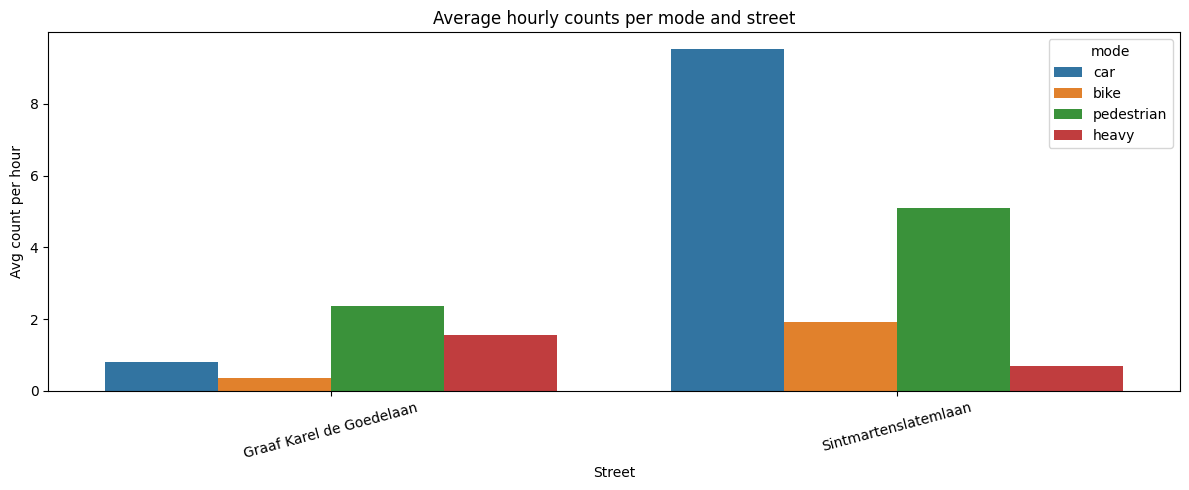

In [31]:
avg_street_mode = (
    df_model.groupby("street_name")[["car","bike","pedestrian","heavy"]]
    .mean()
    .reset_index()
)

avg_street_mode_melt = avg_street_mode.melt(
    id_vars="street_name",
    value_vars=modes,
    var_name="mode",
    value_name="avg_per_hour"
)

plt.figure(figsize=(12,5))
sns.barplot(
    data=avg_street_mode_melt,
    x="street_name",
    y="avg_per_hour",
    hue="mode"
)
plt.title("Average hourly counts per mode and street")
plt.xlabel("Street")
plt.ylabel("Avg count per hour")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Future Traffic Prediction

Using our trained Random Forest models to predict future traffic volumes for the upcoming week. This section demonstrates how the model can forecast traffic patterns under different conditions and scenarios.

**Methodology:**
- Generate future timestamps for the prediction period
- Apply temporal features (hour, day of week, weekend indicator)
- Include holiday and school vacation flags
- Use median weather conditions from historical data
- Predict traffic volumes for each transportation mode

In [32]:
import pandas as pd

# last timestamp in your data
last_dt = df_model["datetime"].max()

# Find the next Monday to ensure a complete week (Monday-Sunday)
days_until_monday = (7 - last_dt.dayofweek) % 7
if days_until_monday == 0:
    days_until_monday = 7  # If today is Monday, go to next Monday
next_monday = last_dt + pd.Timedelta(days=days_until_monday)

# Start from midnight of next Monday
start_date = next_monday.replace(hour=0, minute=0, second=0, microsecond=0)

# Generate exactly 7 days (168 hours) from Monday to Sunday
future_hours = 24 * 7  # one full week
future_index = pd.date_range(
    start=start_date,
    periods=future_hours,
    freq="H"
)

future = pd.DataFrame({"datetime": future_index})
future["date_only"] = future["datetime"].dt.date
future["hour"] = future["datetime"].dt.hour
future["dayofweek"] = future["datetime"].dt.dayofweek
future["is_weekend"] = future["dayofweek"].isin([5, 6]).astype(int)

print(f"Last data timestamp: {last_dt}")
print(f"Prediction week starts: {start_date} (Monday)")
print(f"Prediction week ends: {future_index[-1]}")
print(f"Days covered: {future['day_name'].unique() if 'day_name' in future.columns else sorted(future['dayofweek'].unique())}")


Last data timestamp: 2026-01-06 08:00:00+01:00
Prediction week starts: 2026-01-12 00:00:00+01:00 (Monday)
Prediction week ends: 2026-01-18 23:00:00+01:00
Days covered: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]


C:\Users\hamza\AppData\Local\Temp\ipykernel_60076\3518765768.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(


In [33]:
future = future.merge(
    holidays[["date", "is_holiday"]],
    left_on="date_only", right_on="date", how="left"
)
future = future.merge(
    vac[["date", "is_school_vacation"]],
    left_on="date_only", right_on="date", how="left"
)

future["is_holiday"] = future["is_holiday"].fillna(0).astype(int)
future["is_school_vacation"] = future["is_school_vacation"].fillna(0).astype(int)


In [34]:
street_code_map = dict(df_model[["street_name","street_code"]].drop_duplicates().values)
future["street_code"] = street_code_map["Sintmartenslatemlaan"]  # choose street

# Simple weather scenario: reuse median values from history
for col in ["temperature_c","precipitation_mm","cloud_cover_pct","wind_speed_kmh"]:
    future[col] = df_model[col].median()

# For a rainy scenario, you could set:
# future["precipitation_mm"] = df_model["precipitation_mm"].quantile(0.8)


In [35]:
future_preds = future.copy()

for t in targets:  # ["car","bike","heavy","pedestrian","total_people"]
    rf = models[t]
    future_preds[f"pred_{t}"] = rf.predict(future[feature_cols])


In [36]:
future_preds.head()
future_preds.columns
future_preds[["datetime","pred_car","pred_bike","pred_pedestrian","pred_heavy","pred_total_people"]].head()


datetime  pred_car  pred_bike  pred_pedestrian  pred_heavy  \
0 2026-01-12 00:00:00+01:00       0.0        0.0              0.0         0.0   
1 2026-01-12 01:00:00+01:00       0.0        0.0              0.0         0.0   
2 2026-01-12 02:00:00+01:00       0.0        0.0              0.0         0.0   
3 2026-01-12 03:00:00+01:00       0.0        0.0              0.0         0.0   
4 2026-01-12 04:00:00+01:00       0.0        0.0              0.0         0.0   

   pred_total_people  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

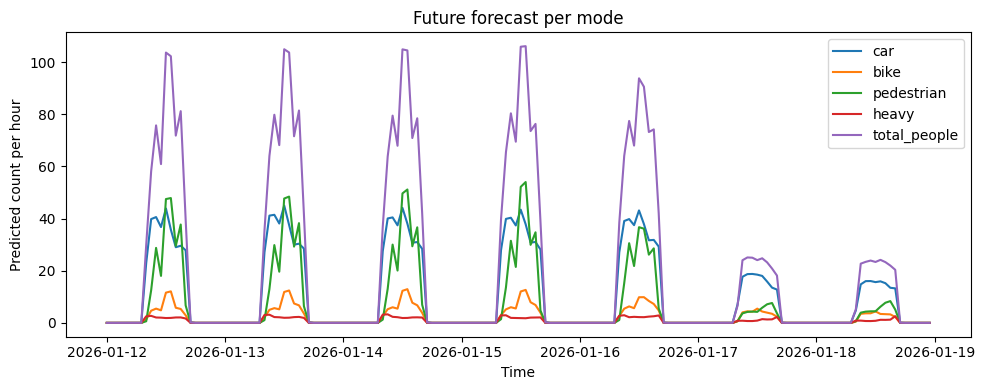

In [37]:
modes = ["car","bike","pedestrian","heavy","total_people"]

# 1) One combined plot (all modes)
plt.figure(figsize=(10,4))
for m in modes:
    plt.plot(future_preds["datetime"],
             future_preds[f"pred_{m}"],
             label=m)
plt.xlabel("Time")
plt.ylabel("Predicted count per hour")
plt.title("Future forecast per mode")
plt.legend()
plt.tight_layout()
plt.show()




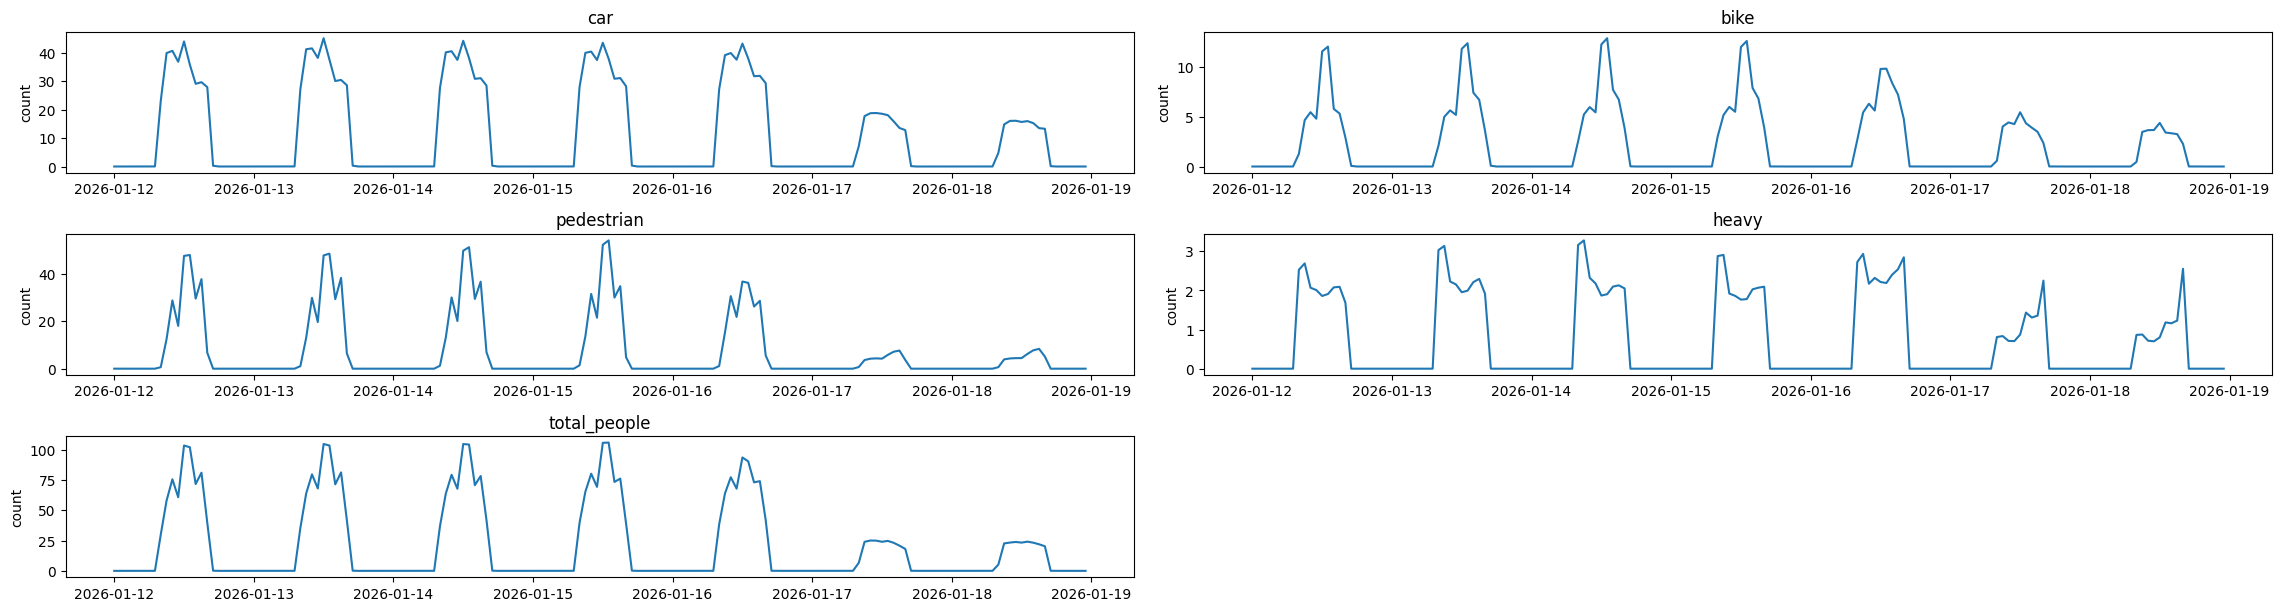

In [38]:
# 2) Small multiples: one subplot per mode
plt.figure(figsize=(23,8))
for i, m in enumerate(modes, 1):
    plt.subplot(4,2,i)
    plt.plot(future_preds["datetime"],
             future_preds[f"pred_{m}"])
    plt.title(m)
    plt.ylabel("count")
plt.tight_layout()
plt.show()

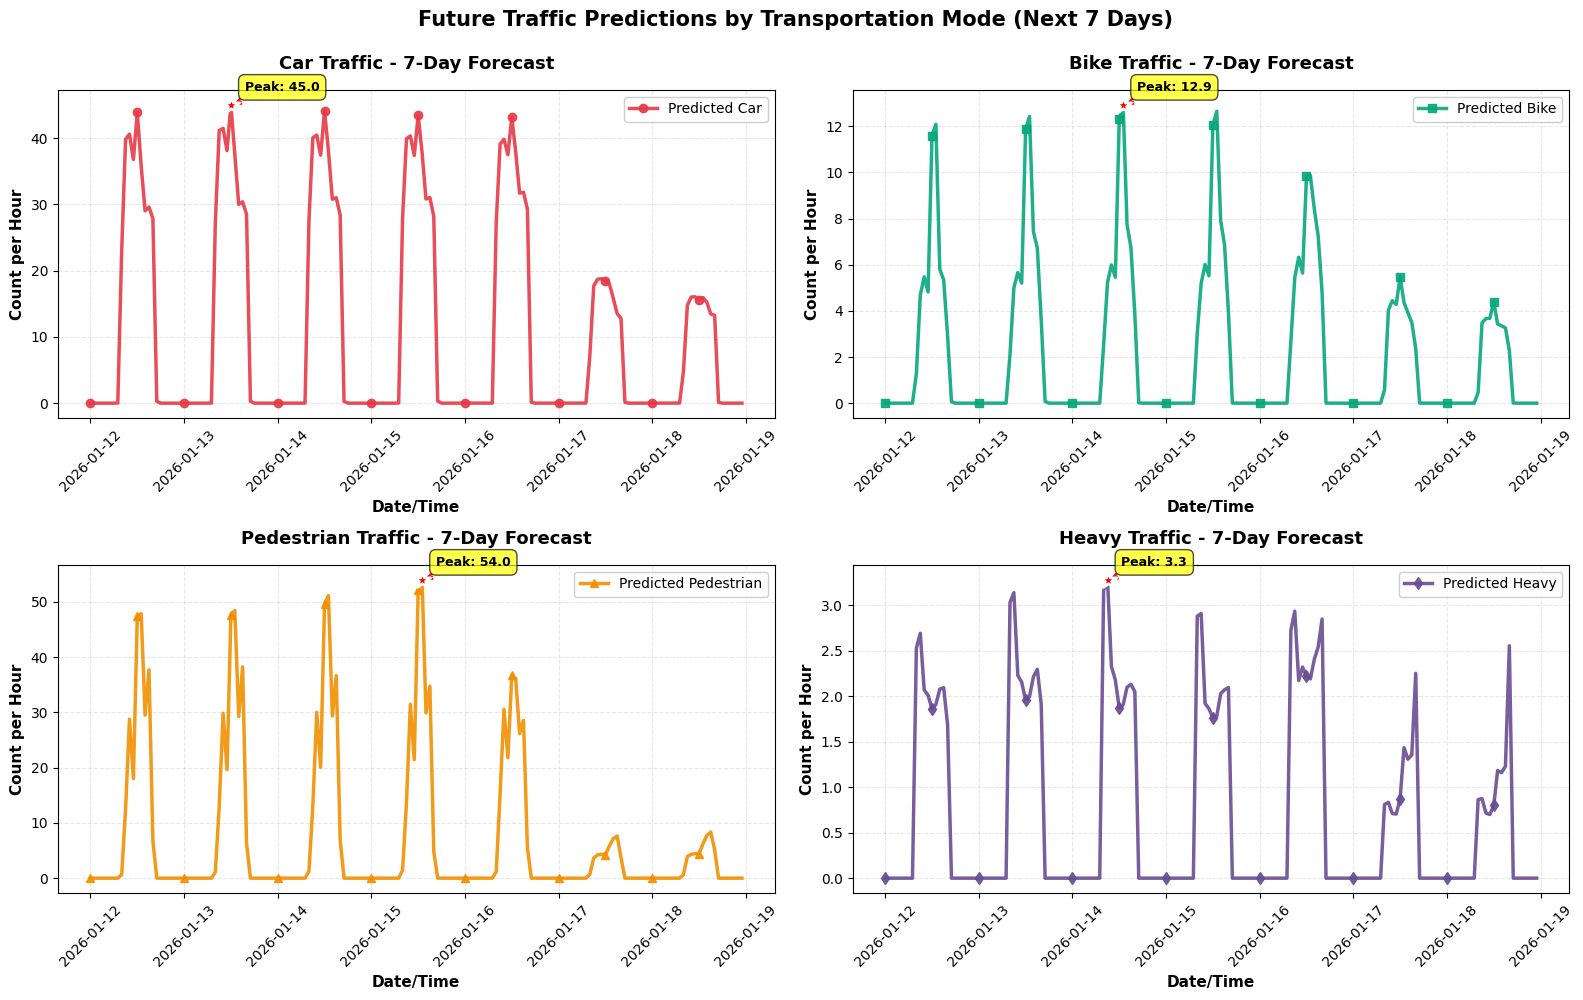

In [39]:
# Future predictions by mode - individual time series
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

colors_mode = {'car': '#E63946', 'bike': '#06A77D', 'pedestrian': '#F18F01', 'heavy': '#6A4C93'}
markers_mode = {'car': 'o', 'bike': 's', 'pedestrian': '^', 'heavy': 'd'}

# Use only the 4 modes that have subplots
plot_modes = ["car", "bike", "pedestrian", "heavy"]

for idx, mode in enumerate(plot_modes):
    axes[idx].plot(future_preds["datetime"], 
                   future_preds[f"pred_{mode}"],
                   color=colors_mode[mode],
                   linewidth=2.5,
                   marker=markers_mode[mode],
                   markersize=6,
                   markevery=12,
                   alpha=0.9,
                   label=f'Predicted {mode.capitalize()}')
    
    axes[idx].set_xlabel('Date/Time', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Count per Hour', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'{mode.capitalize()} Traffic - 7-Day Forecast', 
                       fontweight='bold', fontsize=13, pad=15)
    axes[idx].grid(True, alpha=0.3, linestyle='--')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend(fontsize=10, loc='upper right', framealpha=0.95)
    
    # Add min/max annotations
    max_val = future_preds[f"pred_{mode}"].max()
    max_idx = future_preds[f"pred_{mode}"].idxmax()
    max_time = future_preds.loc[max_idx, "datetime"]
    
    axes[idx].scatter([max_time], [max_val], color='red', s=150, 
                     zorder=5, edgecolors='white', linewidth=2, marker='*')
    axes[idx].annotate(f'Peak: {max_val:.1f}', 
                      xy=(max_time, max_val), 
                      xytext=(10, 10), textcoords='offset points',
                      fontsize=9, fontweight='bold',
                      bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                      arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

fig.suptitle('Future Traffic Predictions by Transportation Mode (Next 7 Days)', 
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

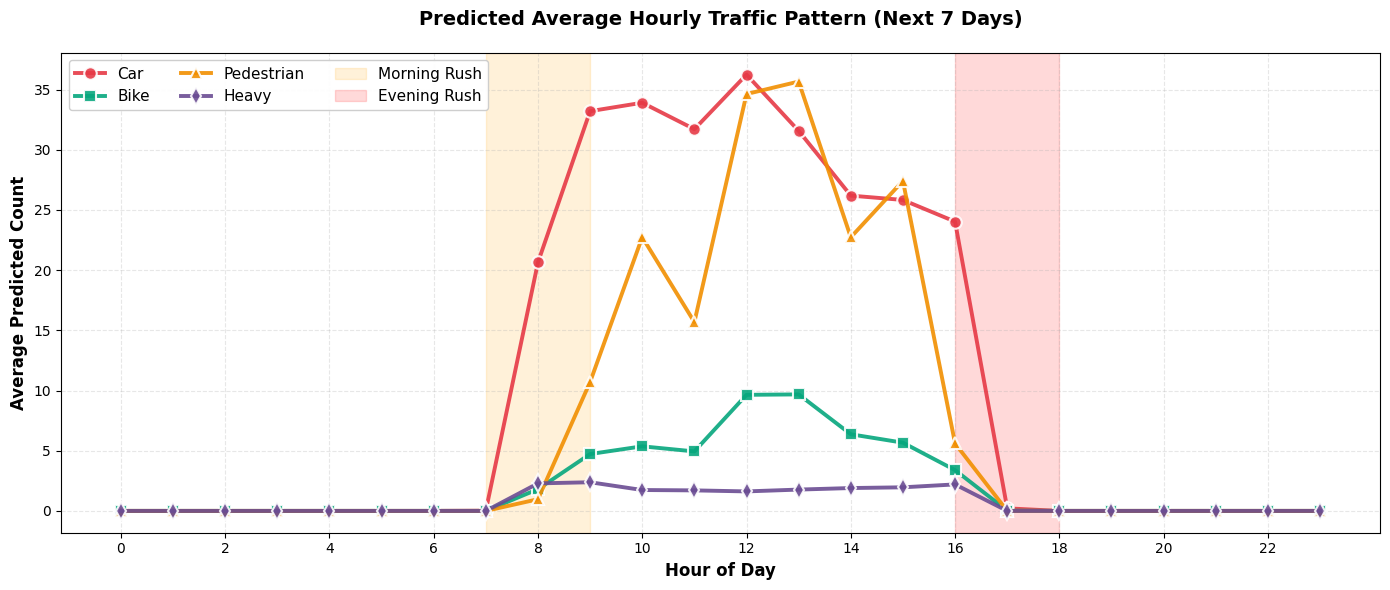

In [40]:
# Hourly average predictions by mode for the next week
plot_modes = ["car", "bike", "pedestrian", "heavy"]
future_hourly = future_preds.groupby("hour")[[f"pred_{m}" for m in plot_modes]].mean()

plt.figure(figsize=(14, 6))

for mode in plot_modes:
    plt.plot(future_hourly.index, 
             future_hourly[f"pred_{mode}"],
             color=colors_mode[mode],
             marker=markers_mode[mode],
             linewidth=2.8,
             markersize=9,
             label=f'{mode.capitalize()}',
             markeredgecolor='white',
             markeredgewidth=1.5,
             alpha=0.9)

plt.xlabel('Hour of Day', fontweight='bold', fontsize=12)
plt.ylabel('Average Predicted Count', fontweight='bold', fontsize=12)
plt.title('Predicted Average Hourly Traffic Pattern (Next 7 Days)', 
         fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(0, 24, 2), fontsize=10)
plt.legend(fontsize=11, loc='upper left', framealpha=0.95, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--')

# Highlight peak traffic hours (7-9 AM and 4-6 PM)
plt.axvspan(7, 9, alpha=0.15, color='orange', label='Morning Rush')
plt.axvspan(16, 18, alpha=0.15, color='red', label='Evening Rush')
plt.legend(fontsize=11, loc='upper left', framealpha=0.95, ncol=3)
plt.tight_layout()
plt.show()

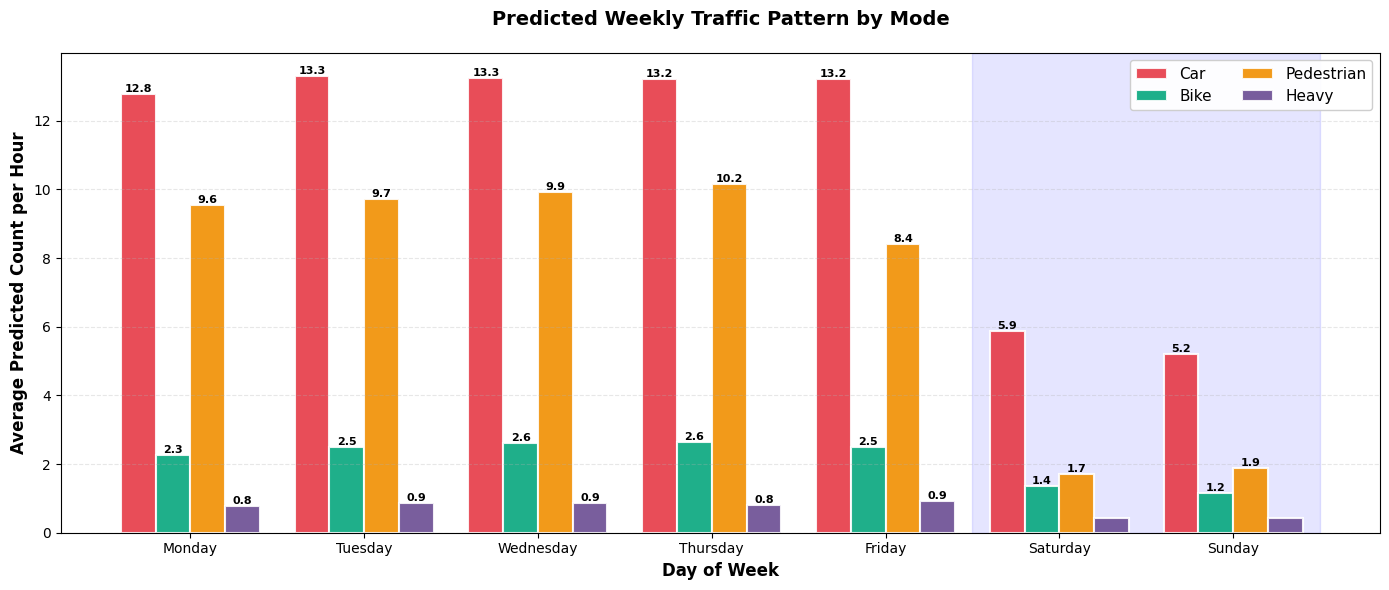

In [41]:
# Day-of-week pattern for future predictions
plot_modes = ["car", "bike", "pedestrian", "heavy"]
future_preds["day_name"] = future_preds["datetime"].dt.day_name()
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

future_daily = future_preds.groupby("day_name")[[f"pred_{m}" for m in plot_modes]].mean()
future_daily = future_daily.reindex(day_order)

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(day_order))
width = 0.2

for i, mode in enumerate(plot_modes):
    offset = (i - len(plot_modes)/2 + 0.5) * width
    bars = ax.bar(x + offset, 
                  future_daily[f"pred_{mode}"], 
                  width, 
                  label=mode.capitalize(),
                  color=colors_mode[mode],
                  edgecolor='white',
                  linewidth=1.5,
                  alpha=0.9)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0.5:  # Only show label if bar is visible
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', 
                   fontweight='bold', fontsize=8)

ax.set_xlabel('Day of Week', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Predicted Count per Hour', fontweight='bold', fontsize=12)
ax.set_title('Predicted Weekly Traffic Pattern by Mode', 
            fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(day_order, fontsize=10)
ax.legend(fontsize=11, loc='upper right', framealpha=0.95, ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Highlight weekend (only if Saturday and Sunday are in the data)
if 'Saturday' in day_order and 'Sunday' in day_order:
    sat_idx = day_order.index('Saturday')
    sun_idx = day_order.index('Sunday')
    ax.axvspan(sat_idx - 0.5, sun_idx + 0.5, alpha=0.1, color='blue', zorder=0)

plt.tight_layout()
plt.show()


FUTURE TRAFFIC PREDICTIONS SUMMARY (Next 7 Days)
      Mode      Mean   Std Dev  Min       Max  Total (7 days)
       Car 10.982007 15.617804  0.0 45.025912     1844.977223
      Bike  2.150383  3.375254  0.0 12.932479      361.264366
Pedestrian  7.339606 13.867568  0.0 54.025518     1233.053816
     Heavy  0.731663  1.036008  0.0  3.281154      122.919402


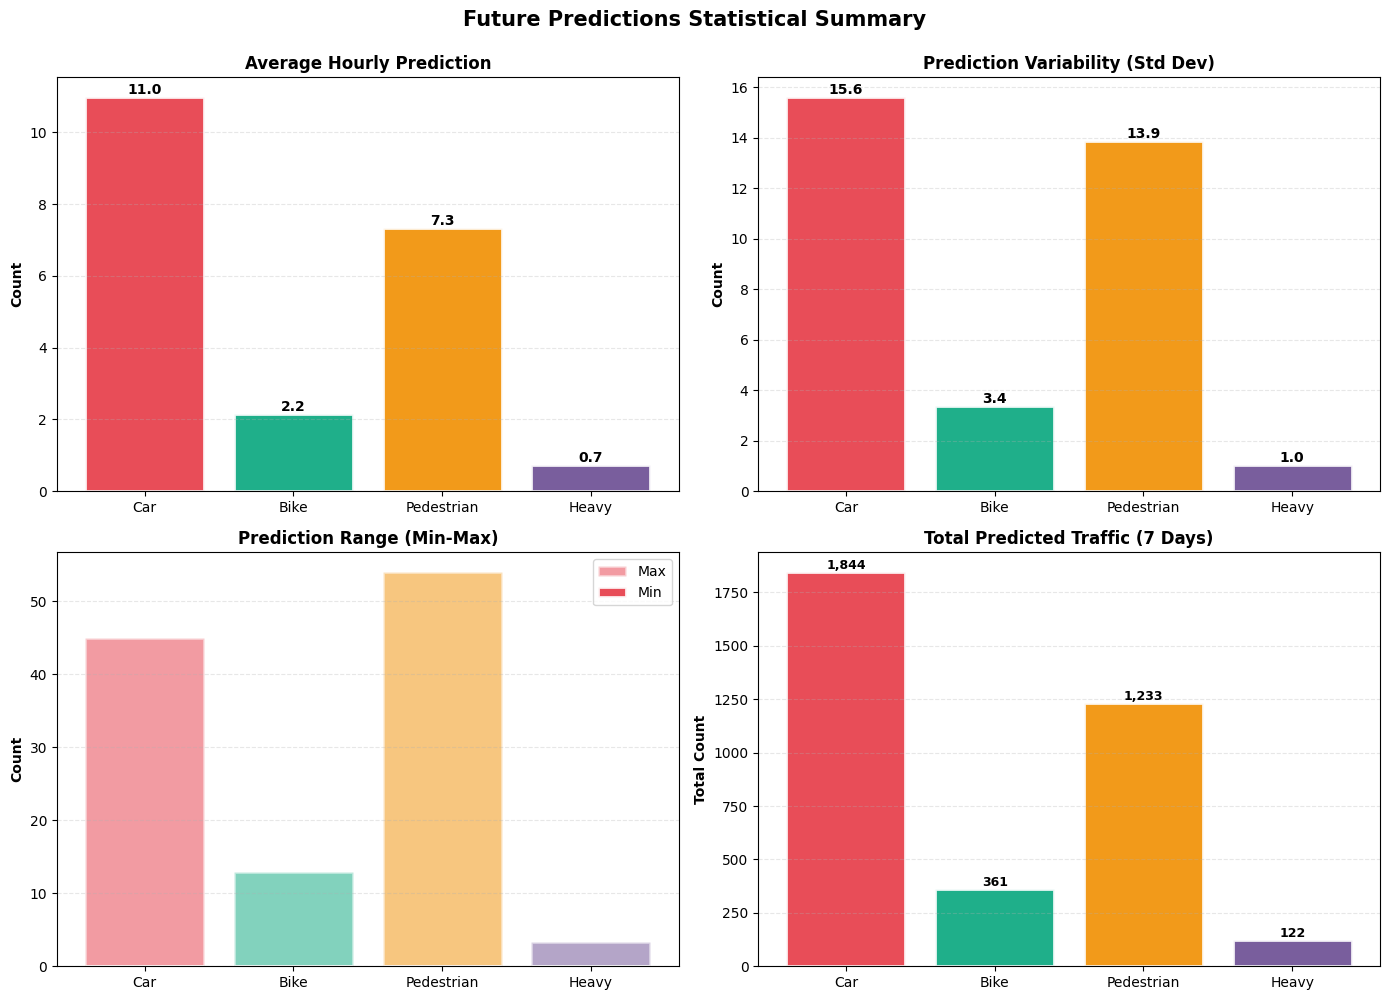

In [42]:
# Summary statistics table for future predictions
plot_modes = ["car", "bike", "pedestrian", "heavy"]
summary_stats = pd.DataFrame({
    'Mode': [m.capitalize() for m in plot_modes],
    'Mean': [future_preds[f"pred_{m}"].mean() for m in plot_modes],
    'Std Dev': [future_preds[f"pred_{m}"].std() for m in plot_modes],
    'Min': [future_preds[f"pred_{m}"].min() for m in plot_modes],
    'Max': [future_preds[f"pred_{m}"].max() for m in plot_modes],
    'Total (7 days)': [future_preds[f"pred_{m}"].sum() for m in plot_modes]
})

# Display the table
print("\n" + "="*70)
print("FUTURE TRAFFIC PREDICTIONS SUMMARY (Next 7 Days)")
print("="*70)
print(summary_stats.to_string(index=False))
print("="*70)

# Visualize summary statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mean predictions
axes[0, 0].bar(range(len(plot_modes)), summary_stats['Mean'], 
              color=[colors_mode[m] for m in plot_modes],
              edgecolor='white', linewidth=2, alpha=0.9)
axes[0, 0].set_xticks(range(len(plot_modes)))
axes[0, 0].set_xticklabels([m.capitalize() for m in plot_modes])
axes[0, 0].set_title('Average Hourly Prediction', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(summary_stats['Mean']):
    axes[0, 0].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Standard deviation (variability)
axes[0, 1].bar(range(len(plot_modes)), summary_stats['Std Dev'], 
              color=[colors_mode[m] for m in plot_modes],
              edgecolor='white', linewidth=2, alpha=0.9)
axes[0, 1].set_xticks(range(len(plot_modes)))
axes[0, 1].set_xticklabels([m.capitalize() for m in plot_modes])
axes[0, 1].set_title('Prediction Variability (Std Dev)', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(summary_stats['Std Dev']):
    axes[0, 1].text(i, v, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Range (Min to Max)
x_pos = np.arange(len(plot_modes))
axes[1, 0].bar(x_pos, summary_stats['Max'], 
              color=[colors_mode[m] for m in plot_modes],
              edgecolor='white', linewidth=2, alpha=0.5, label='Max')
axes[1, 0].bar(x_pos, summary_stats['Min'], 
              color=[colors_mode[m] for m in plot_modes],
              edgecolor='white', linewidth=2, alpha=0.9, label='Min')
axes[1, 0].set_xticks(range(len(plot_modes)))
axes[1, 0].set_xticklabels([m.capitalize() for m in plot_modes])
axes[1, 0].set_title('Prediction Range (Min-Max)', fontweight='bold', fontsize=12)
axes[1, 0].set_ylabel('Count', fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')

# Plot 4: Total weekly traffic
axes[1, 1].bar(range(len(plot_modes)), summary_stats['Total (7 days)'], 
              color=[colors_mode[m] for m in plot_modes],
              edgecolor='white', linewidth=2, alpha=0.9)
axes[1, 1].set_xticks(range(len(plot_modes)))
axes[1, 1].set_xticklabels([m.capitalize() for m in plot_modes])
axes[1, 1].set_title('Total Predicted Traffic (7 Days)', fontweight='bold', fontsize=12)
axes[1, 1].set_ylabel('Total Count', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(summary_stats['Total (7 days)']):
    axes[1, 1].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

fig.suptitle('Future Predictions Statistical Summary', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

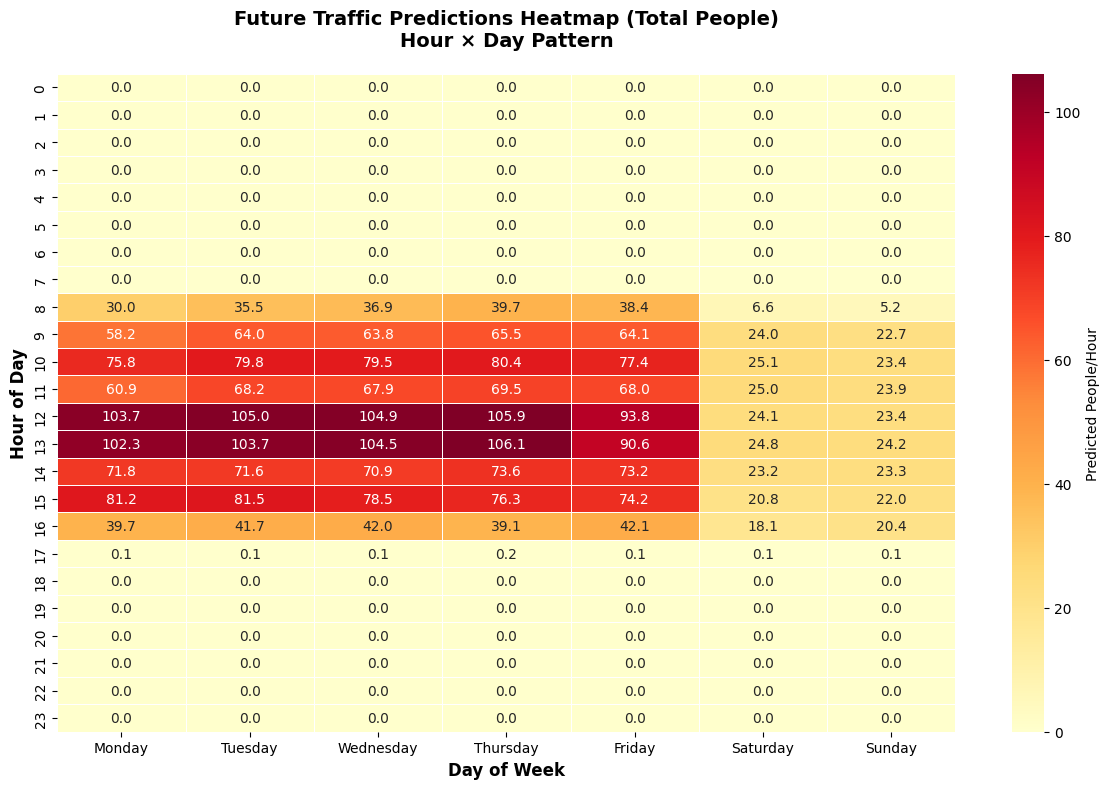

In [43]:
# Heatmap: Hour vs Day for total predicted traffic
future_preds["day_name"] = future_preds["datetime"].dt.day_name()
heatmap_data = future_preds.pivot_table(
    values='pred_total_people', 
    index='hour', 
    columns='day_name', 
    aggfunc='mean'
)

# Reorder columns to show Monday to Sunday
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data[day_order]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, 
           cmap='YlOrRd', 
           annot=True, 
           fmt='.1f', 
           cbar_kws={'label': 'Predicted People/Hour'},
           linewidths=0.5,
           linecolor='white')

plt.xlabel('Day of Week', fontweight='bold', fontsize=12)
plt.ylabel('Hour of Day', fontweight='bold', fontsize=12)
plt.title('Future Traffic Predictions Heatmap (Total People)\nHour × Day Pattern', 
         fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

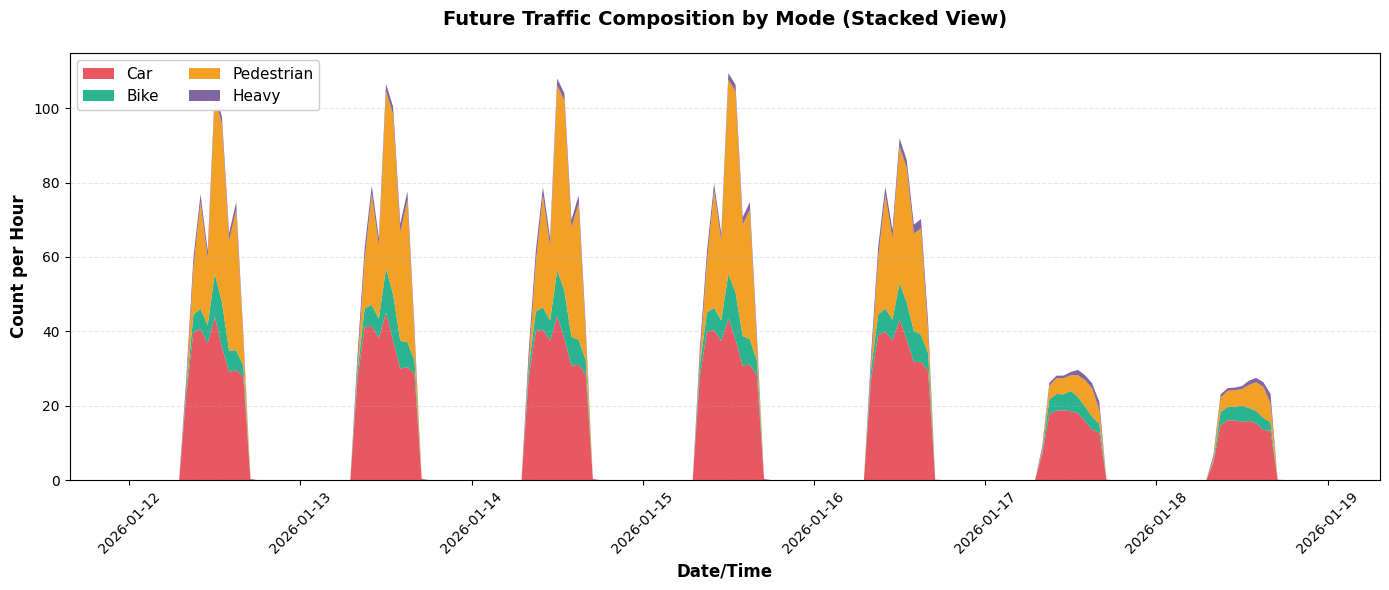

In [44]:
# Mode share distribution over time (stacked area for future predictions)
plot_modes = ["car", "bike", "pedestrian", "heavy"]
plt.figure(figsize=(14, 6))

# Prepare data for stacked area plot
mode_data = [future_preds[f"pred_{m}"] for m in plot_modes]

plt.stackplot(future_preds["datetime"], 
             *mode_data,
             labels=[m.capitalize() for m in plot_modes],
             colors=[colors_mode[m] for m in plot_modes],
             alpha=0.85)

plt.xlabel('Date/Time', fontweight='bold', fontsize=12)
plt.ylabel('Count per Hour', fontweight='bold', fontsize=12)
plt.title('Future Traffic Composition by Mode (Stacked View)', 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper left', fontsize=11, framealpha=0.95, ncol=2)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Parking Scenario Analysis

In this section, we evaluate the impact of different parking policies on traffic patterns around the campus. We simulate three distinct scenarios to understand how parking availability affects transportation mode choices:

### Parking Scenarios:

1. **Open Parking (Baseline)**: Current situation with free and available parking
2. **Closed Parking**: Complete parking restriction, simulating:
   - 50% reduction in car traffic
   - 40% increase in bicycle usage
   - 30% increase in pedestrian traffic
3. **Paid Parking**: Introduction of parking fees, leading to:
   - 20% reduction in car traffic
   - 20% increase in bicycle usage
   - 5% increase in pedestrian traffic

### Methodology:

We apply these adjustment factors to our Random Forest predictions to forecast traffic patterns under each scenario. This analysis helps campus administrators understand the potential effects of parking policy changes on overall traffic distribution and volume.

The following cells demonstrate the scenario implementation, comparative analysis, and visualization of predicted impacts across all transportation modes.

In [45]:
future_preds = future.copy()

for t in targets:
    rf = models[t]
    future_preds[f"pred_{t}"] = rf.predict(future[feature_cols])


In [46]:
future_preds[["datetime","pred_car","pred_bike","pred_pedestrian","pred_heavy","pred_total_people"]].head()


datetime  pred_car  pred_bike  pred_pedestrian  pred_heavy  \
0 2026-01-12 00:00:00+01:00       0.0        0.0              0.0         0.0   
1 2026-01-12 01:00:00+01:00       0.0        0.0              0.0         0.0   
2 2026-01-12 02:00:00+01:00       0.0        0.0              0.0         0.0   
3 2026-01-12 03:00:00+01:00       0.0        0.0              0.0         0.0   
4 2026-01-12 04:00:00+01:00       0.0        0.0              0.0         0.0   

   pred_total_people  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0

In [47]:
def adjust_for_parking(row, scenario):
    car = row["pred_car"]
    bike = row["pred_bike"]
    ped = row["pred_pedestrian"]
    heavy = row["pred_heavy"]

    if scenario == "closed":
        car *= 0.5
        bike *= 1.40
        ped *= 1.30
    elif scenario == "paid":
        car *= 0.80
        bike *= 1.20
        ped *= 1.05
    # if scenario == "open": keep original values

    total = car + bike + ped

    return pd.Series({
        "car": car,
        "bike": bike,
        "pedestrian": ped,
        "heavy": heavy,
        "total_people": total,
    })


In [48]:
scenario_frames = []

for scenario in ["open", "closed", "paid"]:
    adjusted = future_preds.apply(
        adjust_for_parking, axis=1, scenario=scenario
    )
    adjusted["scenario"] = scenario
    adjusted["datetime"] = future_preds["datetime"].values
    adjusted["street_name"] = "Sintmartenslatemlaan"  # Add street name
    scenario_frames.append(adjusted)

scenario_df = pd.concat(scenario_frames, ignore_index=True)


In [49]:
scenario_df.head()


car  bike  pedestrian  heavy  total_people scenario            datetime  \
0  0.0   0.0         0.0    0.0           0.0     open 2026-01-11 23:00:00   
1  0.0   0.0         0.0    0.0           0.0     open 2026-01-12 00:00:00   
2  0.0   0.0         0.0    0.0           0.0     open 2026-01-12 01:00:00   
3  0.0   0.0         0.0    0.0           0.0     open 2026-01-12 02:00:00   
4  0.0   0.0         0.0    0.0           0.0     open 2026-01-12 03:00:00   

            street_name  
0  Sintmartenslatemlaan  
1  Sintmartenslatemlaan  
2  Sintmartenslatemlaan  
3  Sintmartenslatemlaan  
4  Sintmartenslatemlaan

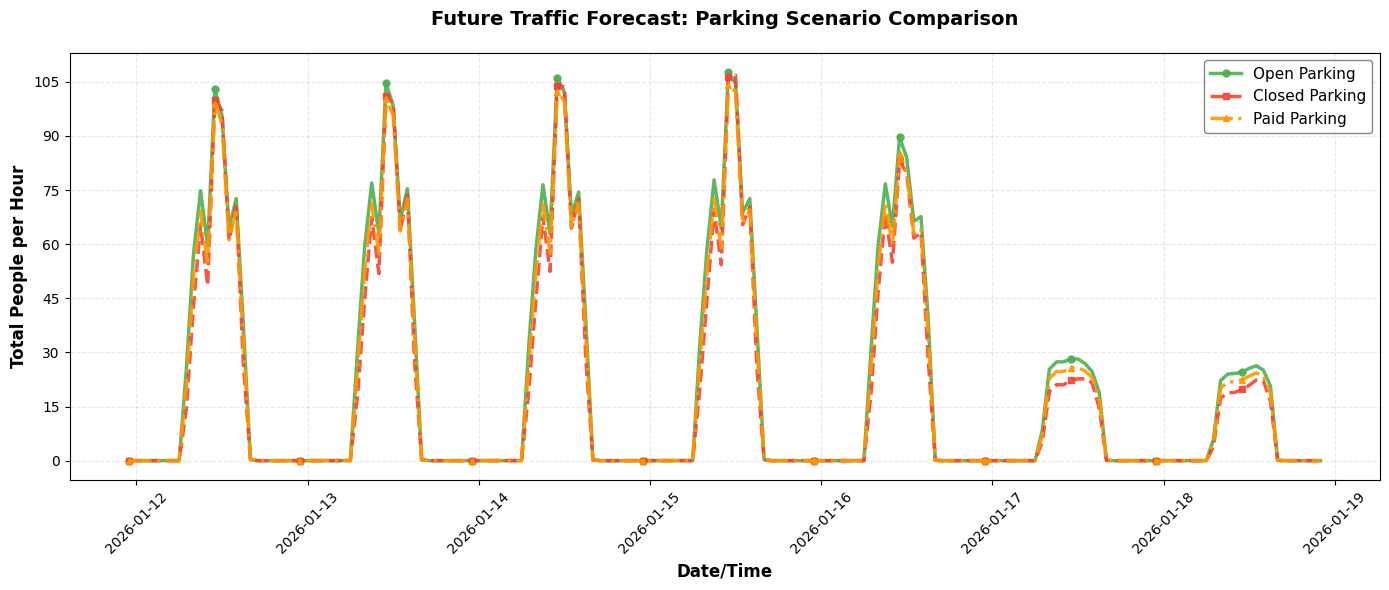

In [50]:
import numpy as np

plt.figure(figsize=(14, 6))

# Define scenario colors and styles
scenario_styles = {
    'open': {'color': '#4CAF50', 'linestyle': '-', 'linewidth': 2.5, 'marker': 'o', 'label': 'Open Parking'},
    'closed': {'color': '#F44336', 'linestyle': '--', 'linewidth': 2.5, 'marker': 's', 'label': 'Closed Parking'},
    'paid': {'color': '#FF9800', 'linestyle': '-.', 'linewidth': 2.5, 'marker': '^', 'label': 'Paid Parking'}
}

# Plot each scenario
for scenario in ['open', 'closed', 'paid']:
    sub = scenario_df[scenario_df["scenario"] == scenario]
    style = scenario_styles[scenario]
    plt.plot(sub["datetime"], sub["total_people"],
             label=style['label'],
             color=style['color'],
             linestyle=style['linestyle'],
             linewidth=style['linewidth'],
             marker=style['marker'],
             markersize=5,
             markevery=12,
             alpha=0.9)

plt.xlabel("Date/Time", fontsize=12, fontweight='bold')
plt.ylabel("Total People per Hour", fontsize=12, fontweight='bold')
plt.title("Future Traffic Forecast: Parking Scenario Comparison", 
         fontsize=14, fontweight='bold', pad=20)
plt.legend(fontsize=11, loc='best', framealpha=0.95, edgecolor='gray')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# ✅ Set y-axis ticks every 10
max_y = scenario_df["total_people"].max()
plt.yticks(np.arange(0, max_y + 10, 15))

plt.tight_layout()
plt.show()


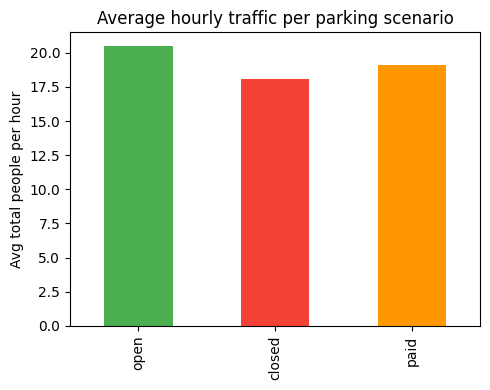

In [51]:
mean_open   = scenario_df[scenario_df["scenario"]=="open"]["total_people"].mean()
mean_closed = scenario_df[scenario_df["scenario"]=="closed"]["total_people"].mean()
mean_paid   = scenario_df[scenario_df["scenario"]=="paid"]["total_people"].mean()

avg_totals = pd.Series(
    [mean_open, mean_closed, mean_paid],
    index=["open","closed","paid"]
)

plt.figure(figsize=(5,4))
avg_totals.plot(kind="bar", color=["#4CAF50","#F44336","#FF9800"])
plt.ylabel("Avg total people per hour")
plt.title("Average hourly traffic per parking scenario")
plt.tight_layout()
plt.show()


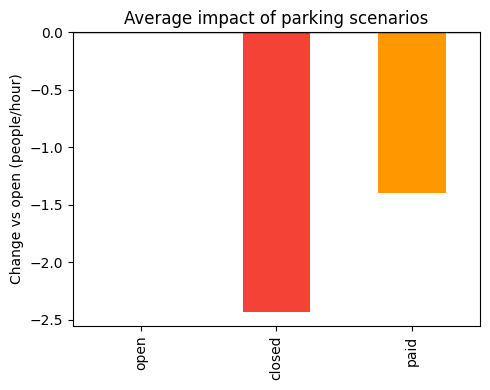

In [52]:
diff_from_open = avg_totals - mean_open

plt.figure(figsize=(5,4))
diff_from_open.plot(kind="bar", color=["#9E9E9E","#F44336","#FF9800"])
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Change vs open (people/hour)")
plt.title("Average impact of parking scenarios")
plt.tight_layout()
plt.show()


In [53]:
sint_scen = scenario_df[
    scenario_df["street_name"] == "Sintmartenslatemlaan"
].copy()


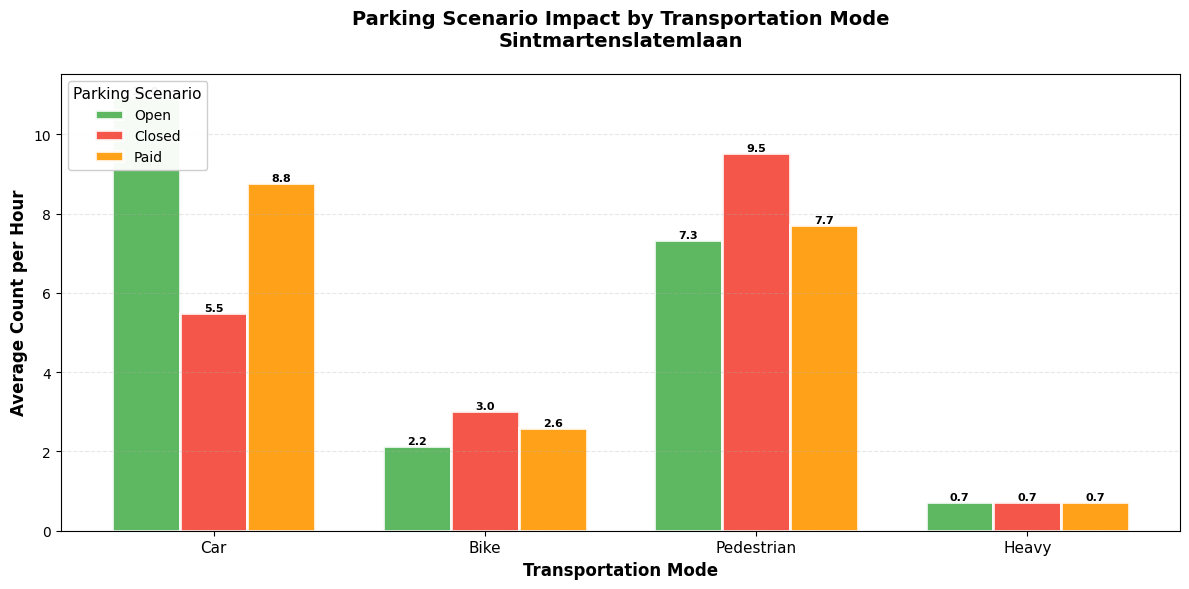

In [54]:
mode_cols = ["car","bike","pedestrian","heavy"]

avg_mode_scen = (
    sint_scen.groupby("scenario")[mode_cols]
    .mean()
    .T  # modes as rows
)

# Create improved bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Define colors for each scenario
scenario_colors = {'open': '#4CAF50', 'closed': '#F44336', 'paid': '#FF9800'}
x = np.arange(len(mode_cols))
width = 0.25

# Plot bars for each scenario
for i, scenario in enumerate(['open', 'closed', 'paid']):
    offset = (i - 1) * width
    bars = ax.bar(x + offset, avg_mode_scen[scenario], width, 
                  label=scenario.capitalize(), 
                  color=scenario_colors[scenario],
                  edgecolor='white',
                  linewidth=2,
                  alpha=0.9)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}',
               ha='center', va='bottom', fontweight='bold', fontsize=8)

# Customize plot
ax.set_xlabel('Transportation Mode', fontweight='bold', fontsize=12)
ax.set_ylabel('Average Count per Hour', fontweight='bold', fontsize=12)
ax.set_title('Parking Scenario Impact by Transportation Mode\nSintmartenslatemlaan', 
            fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in mode_cols], fontsize=11)
ax.legend(title='Parking Scenario', fontsize=10, title_fontsize=11, 
         loc='upper left', framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


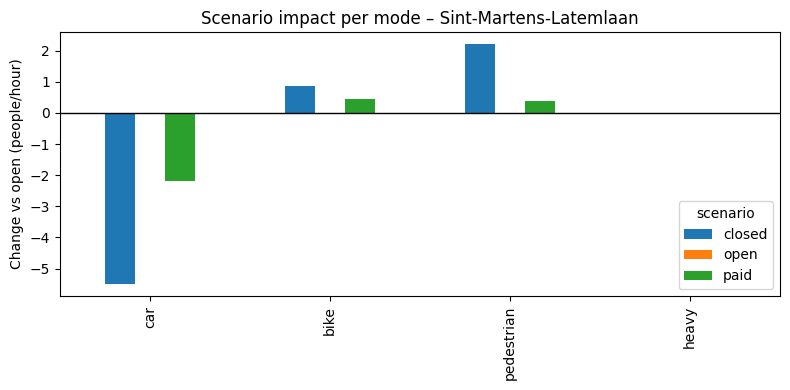

In [55]:
base = avg_mode_scen["open"]
diff = avg_mode_scen.sub(base, axis=0)

diff.plot(kind="bar", figsize=(8,4))
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Change vs open (people/hour)")
plt.title("Scenario impact per mode – Sint-Martens-Latemlaan")
plt.tight_layout()
plt.show()


In [56]:
# these will come from UI widgets later
start_date = "2025-11-20"   # user-chosen, within your data range
end_date   = "2026-01-01"
scenario   = "closed"       # "open", "closed", or "paid"
weeks_ahead = 4             # user-chosen, e.g. 1–15


In [57]:
baseline = df_model[
    (df_model["datetime"] >= start_date) &
    (df_model["datetime"] <= end_date)
].copy()


In [58]:
last_dt = baseline["datetime"].max()

future_hours = 24 * weeks_ahead
future_index = pd.date_range(
    start=last_dt + pd.Timedelta(hours=1),
    periods=future_hours,
    freq="H"
)

future = pd.DataFrame({"datetime": future_index})
future["date_only"]  = future["datetime"].dt.date
future["hour"]       = future["datetime"].dt.hour
future["dayofweek"]  = future["datetime"].dt.dayofweek
future["is_weekend"] = future["dayofweek"].isin([5, 6]).astype(int)

# add holidays & vacations (same as before)
future = future.merge(holidays[["date","is_holiday"]],
                      left_on="date_only", right_on="date", how="left")
future = future.merge(vac[["date","is_school_vacation"]],
                      left_on="date_only", right_on="date", how="left")
future["is_holiday"] = future["is_holiday"].fillna(0).astype(int)
future["is_school_vacation"] = future["is_school_vacation"].fillna(0).astype(int)

# choose one street, e.g. Sintmartenslatemlaan
street_code_sint = df_model.loc[
    df_model["street_name"]=="Sintmartenslatemlaan","street_code"
].iloc[0]
future["street_code"] = street_code_sint

# simple weather assumption: median from baseline
for col in ["temperature_c","precipitation_mm","cloud_cover_pct","wind_speed_kmh"]:
    future[col] = baseline[col].median()


C:\Users\hamza\AppData\Local\Temp\ipykernel_60076\3955268285.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_index = pd.date_range(


In [59]:
future_preds = future.copy()

for t in targets:  # ["car","bike","heavy","pedestrian","total_people"]
    rf = models[t]
    future_preds[f"pred_{t}"] = rf.predict(future[feature_cols])


In [60]:
def adjust_for_parking_row(row, scenario):
    car = row["pred_car"]
    bike = row["pred_bike"]
    ped = row["pred_pedestrian"]
    heavy = row["pred_heavy"]

    if scenario == "closed":
        car *= 0.5      # stronger effect so it shows clearly
        bike *= 1.20
        ped *= 1.20
    elif scenario == "paid":
        car *= 0.75
        bike *= 1.10
        ped *= 1.10
    # open = no change

    total = car + bike + ped
    return pd.Series({
        "car": car,
        "bike": bike,
        "pedestrian": ped,
        "heavy": heavy,
        "total_people": total,
    })

future_adj = future_preds.apply(
    adjust_for_parking_row, axis=1, scenario=scenario
)
future_adj["datetime"] = future_preds["datetime"]
future_adj["scenario"] = scenario


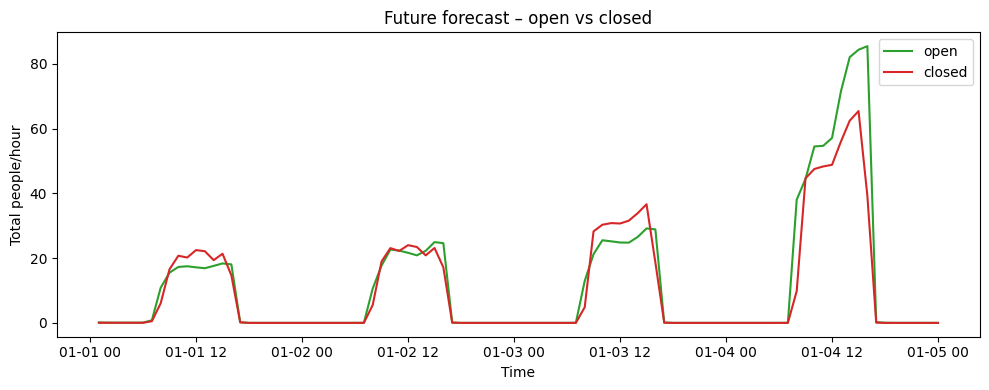

In [61]:
# baseline open = original prediction
future_open = future_preds[["datetime","pred_total_people"]].copy()

plt.figure(figsize=(10,4))
plt.plot(future_open["datetime"], future_open["pred_total_people"],
         label="open", color="tab:green")
plt.plot(future_adj["datetime"], future_adj["total_people"],
         label=scenario, color="tab:red" if scenario=="closed" else "tab:orange")
plt.xlabel("Time")
plt.ylabel("Total people/hour")
plt.title(f"Future forecast – open vs {scenario}")
plt.legend()
plt.tight_layout()
plt.show()


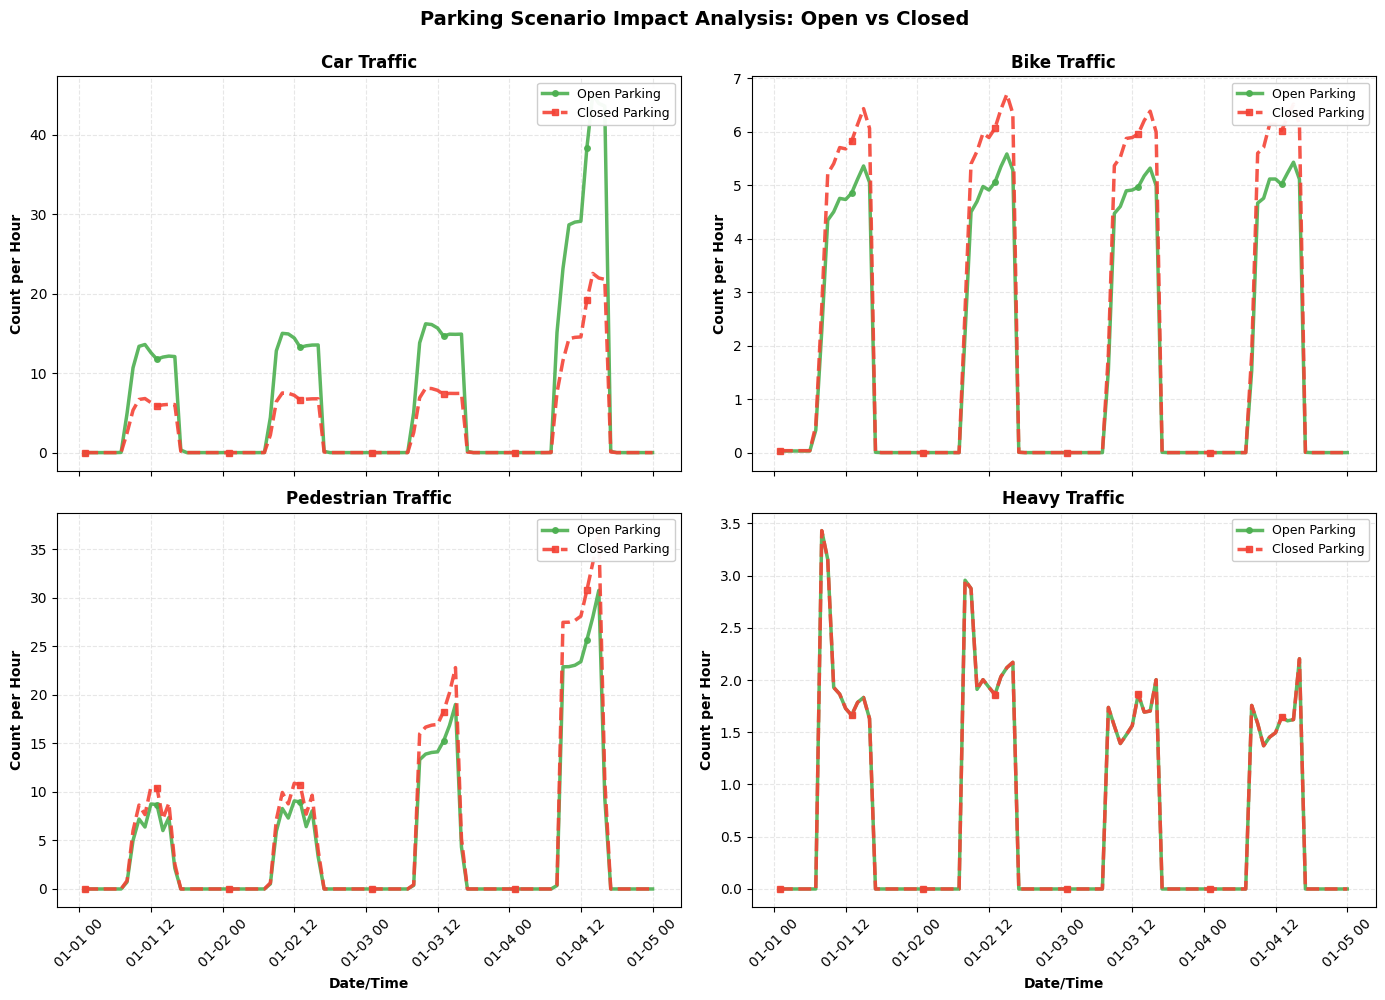

In [62]:
modes = ["car","bike","pedestrian","heavy"]
mode_colors = {'car': '#E63946', 'bike': '#06A77D', 'pedestrian': '#F18F01', 'heavy': '#6A4C93'}

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.ravel()

for ax, m in zip(axes, modes):
    # Plot open scenario with solid line
    ax.plot(future_open["datetime"],
            future_preds[f"pred_{m}"], 
            label="Open Parking", 
            color='#4CAF50',
            linewidth=2.5,
            marker='o',
            markersize=4,
            markevery=12,
            alpha=0.9)
    
    # Plot adjusted scenario with dashed line
    ax.plot(future_adj["datetime"],
            future_adj[m], 
            label=f"{scenario.capitalize()} Parking",
            color='#F44336' if scenario == "closed" else '#FF9800',
            linewidth=2.5,
            linestyle='--',
            marker='s',
            markersize=4,
            markevery=12,
            alpha=0.9)
    
    ax.set_title(f'{m.capitalize()} Traffic', fontweight='bold', fontsize=12)
    ax.set_ylabel('Count per Hour', fontweight='bold', fontsize=10)
    ax.legend(loc='upper right', fontsize=9, framealpha=0.95)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    ax.tick_params(axis='x', rotation=45)

# Set common x-label for bottom plots
axes[2].set_xlabel('Date/Time', fontweight='bold', fontsize=10)
axes[3].set_xlabel('Date/Time', fontweight='bold', fontsize=10)

fig.suptitle(f'Parking Scenario Impact Analysis: Open vs {scenario.capitalize()}', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [64]:
# Export df_model using CSV (more reliable than parquet)
df_model.to_csv("models/df_model.csv", index=False)
print(f"✅ Exported {len(df_model)} rows to models/df_model.csv")

✅ Exported 2467 rows to models/df_model.csv


In [65]:
import joblib
import os

# Create directories
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Export models and metadata to the correct directories
joblib.dump(models, "models/models.pkl")
joblib.dump(targets, "models/targets.pkl")
joblib.dump(feature_cols, "models/feature_cols.pkl")

print("✅ Exported models to models/ directory")
print(f"Models available: {list(models.keys())}")
print(f"Feature columns: {feature_cols}")
print(f"Targets: {targets}")

✅ Exported models to models/ directory
Models available: ['car', 'bike', 'heavy', 'pedestrian', 'total_people']
Feature columns: ['hour', 'dayofweek', 'is_weekend', 'is_holiday', 'is_school_vacation', 'temperature_c', 'precipitation_mm', 'cloud_cover_pct', 'wind_speed_kmh', 'street_code']
Targets: ['car', 'bike', 'heavy', 'pedestrian', 'total_people']
